In [1]:
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

from data.data_generators import *
import torch


def get_available_gpu_with_most_memory():
    gpu_memory = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch to the GPU to accurately measure memory
        gpu_memory.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
    
    gpu_memory.sort(key=lambda x: x[1], reverse=True)
    
    return gpu_memory[0][0]

if torch.cuda.is_available():
    available_gpu = get_available_gpu_with_most_memory()
    if available_gpu == 0:
        device_wta = torch.device("cuda:0")
        device_cnp = torch.device("cuda:0")
    else:
        device_wta = torch.device(f"cuda:{available_gpu}")
        device_cnp = torch.device(f"cuda:{available_gpu}")
else:
    device_wta = torch.device("cpu")
    device_cnp = torch.device("cpu")

print("Device WTA:", device_wta, "Device CNP:", device_cnp)

Device WTA: cuda:0 Device CNP: cuda:0


In [2]:
batch_size = 4
n_max_obs, n_max_tar = 10, 10

t_steps = 200
num_demos = 8
num_classes = 2
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 4
num_val_indiv = num_val//num_classes

colors = ['tomato', 'aqua', 'limegreen', 'gold']

num_inc = 0
num_exc = 0

fixed_obs_ratio = 0.00000

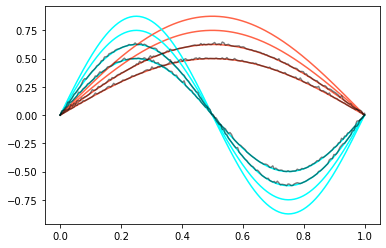

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_demos, 1).unsqueeze(-1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val, 1).unsqueeze(-1)
vy = torch.zeros(num_val, t_steps, dy)

y[0] = torch.unsqueeze(generate_sin(x[0]), 0) / 2.0
y[1] = torch.unsqueeze(generate_sin(x[0] * 2.0), 0) / 2.0

coef = 1
for i in range(num_indiv-1):
    coef += 0.25
    start_ind = (i+1) * num_classes
    y[start_ind] = y[0].clone() * coef
    y[start_ind+1] = y[1].clone() * coef
    
for i in range(num_val):
    noise = torch.unsqueeze(torch.clamp(torch.randn(x[0].shape)*1e-4**0.5, min=0) - noise_clip, 0)
    vy[i] = y[i].clone() + noise

from matplotlib import pyplot as plt

for i in range(num_indiv):
    plt.plot(x[i*num_classes, :, 0].cpu(), y[i*num_classes, :, 0].cpu(), colors[0%num_classes])
    plt.plot(x[i*num_classes+1, :, 0].cpu(), y[i*num_classes+1, :, 0].cpu(), colors[1%num_classes])

for i in range(num_val):
    plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)


x0, y0 = x.to(device_wta), y.to(device_wta)
x1, y1 = x.to(device_cnp), y.to(device_cnp)

In [4]:
def get_batch(x, y, traj_ids, device=device_wta):
    global num_inc, num_exc


    # if the following holds, we condition on 0, -1 or [0, -1] to estimate the rest
    # if not, we condition on random-numbered random points
    if torch.rand(1) < fixed_obs_ratio:
        num_inc += 1
        
        if torch.rand(1) < 0.33:
            n_o = 1  # [0]
            n_t = t_steps - 1
            o_ids = torch.tensor([0])
            t_ids = torch.randperm(t_steps-1)+1  # excluding [0]
        elif torch.rand(1) < 0.66:
            n_o = 1  # [-1]
            n_t = t_steps - 1
            o_ids = torch.tensor([-1])
            t_ids = torch.randperm(t_steps-1)  # excluding [-1]
        else:
            n_o = 2  # [0, -1]
            n_t = t_steps - 2
            o_ids = torch.tensor([0, -1])
            t_ids = torch.randperm(t_steps-2)+1  # excluding [0] and [-1]

        fixed = True
    
    else:
        num_exc += 1
        n_o = torch.randint(1, n_max_obs, (1,)).item()
        n_t = torch.randint(1, n_max_tar, (1,)).item()
        fixed = False

    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)
    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    
    for i in range(len(traj_ids)):
        if not fixed:
            random_query_ids = torch.randperm(t_steps) 
            
            o_ids = random_query_ids[:n_o]
            t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device_wta):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [5]:
model_wta = WTA_CNP(1, 1, n_max_obs, n_max_tar, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size).to(device_wta)
optimizer_wta = torch.optim.Adam(lr=1e-4, params=model_wta.parameters())

model_cnp = CNP(input_dim=1, hidden_dim=158, output_dim=1, n_max_obs=n_max_obs, n_max_tar=n_max_tar, num_layers=3, batch_size=batch_size).to(device_cnp)
optimizer_cnp = torch.optim.Adam(lr=1e-4, params=model_cnp.parameters())

# print("WTA Model:", model_wta)

In [6]:
def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("WTA-CNP:", get_parameter_count(model_wta))
print("CNP:", get_parameter_count(model_cnp))

WTA-CNP: 100486
CNP: 101438


In [7]:
from matplotlib.lines import Line2D


def draw_val_plot(root_folder, epoch):
    plt_y_lim = torch.max(vy) + 0.1

    obs = torch.zeros((batch_size, 1, 1, 2)).to(device_wta)
    for i in range(batch_size):
        obs[i] = torch.Tensor([x[i, 80, 0], y[i, 80, 0]]).unsqueeze(0).unsqueeze(0).to(device_wta)

    tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).to(device_wta)

    with torch.no_grad():
        for i in range(batch_size):
            pred_cnp, _ = model_cnp(obs[i], tar)
            pred_wta, gate = model_wta(obs[i], tar)
            print(pred_wta.shape)

            plt.ylim((-plt_y_lim, plt_y_lim))
            plt.scatter(obs[i,:,:,0].cpu(), obs[i,:,:,1].cpu(), c='k')
            for j in range(model_wta.num_decoders):
                plt.plot(torch.linspace(0, 1, 200), pred_wta[j,i,:,0].cpu(), colors[j], alpha=max(0.2, gate[0, 0, j].item()))  # wta pred
            plt.plot(torch.linspace(0, 1, 200), pred_cnp[:, :, :model_cnp.output_dim].squeeze(0).cpu(), 'b')  # cnp pred
            handles = []
            for j in range(batch_size):
                plt.plot(torch.linspace(0, 1, 200), vy[j].squeeze(-1).cpu(), 'k', alpha=0.05 if j!=i else 0.35)  # data
                handles.append(Line2D([0], [0], label=f'gate{j}: {gate[0, 0, j].item():.4f}', color=colors[j]))

            plt.legend(handles=handles, loc='upper right')

            plt.savefig(f'{root_folder}img/{i}_{epoch}.png')
            plt.close()

In [8]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sines/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 2_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_wta, avg_loss_cnp = 0, 0

val_per_epoch = 1000
min_val_loss_wta, min_val_loss_cnp = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

training_loss_wta, validation_error_wta = [], []
training_loss_cnp, validation_error_cnp = [], []

wta_tr_loss_path = f'{root_folder}wta_training_loss.pt'
wta_val_err_path = f'{root_folder}wta_validation_error.pt'
cnp_tr_loss_path = f'{root_folder}cnp_training_loss.pt'
cnp_val_err_path = f'{root_folder}cnp_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_wta, epoch_loss_cnp = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer_wta.zero_grad()
        optimizer_cnp.zero_grad()

        obs_wta, tar_x_wta, tar_y_wta = get_batch(x, y, traj_ids[i], device_wta)
        obs_cnp, tar_x_cnp, tar_y_cnp = obs_wta.clone(), tar_x_wta.clone(), tar_y_wta.clone()

        pred_wta, gate_wta = model_wta(obs_wta, tar_x_wta)
        pred_cnp, encoded_rep_cnp = model_cnp(obs_cnp, tar_x_cnp)

        loss_wta, wta_nll = model_wta.loss(pred_wta, gate_wta, tar_y_wta)

        loss_wta.backward()
        optimizer_wta.step()

        loss_cnp = model_cnp.loss(pred_cnp, tar_y_cnp)
        loss_cnp.backward()
        optimizer_cnp.step()

        epoch_loss_wta += wta_nll.item()
        epoch_loss_cnp += loss_cnp.item()

    training_loss_wta.append(epoch_loss_wta)
    training_loss_cnp.append(epoch_loss_cnp)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_loss_wta, val_loss_cnp = 0, 0

            for j in range(v_epoch_iter):
                o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j], device=device_wta)
                o_cnp, t_cnp, tr_cnp = o_wta.clone(), t_wta.clone(), tr_wta.clone()

                p_wta, g_wta = model_wta(o_wta, t_wta)
                dec_id = torch.argmax(g_wta.squeeze(1), dim=-1)
                vp_means = p_wta[dec_id, torch.arange(batch_size), :, :dy]
                val_loss_wta += mse_loss(vp_means, tr_wta).item()

                pred_cnp, encoded_rep = model_cnp(o_cnp, t_cnp)
                val_loss_cnp += mse_loss(pred_cnp[:, :, :model_cnp.output_dim], tr_cnp)


            validation_error_wta.append(val_loss_wta)
            if val_loss_wta < min_val_loss_wta:
                min_val_loss_wta = val_loss_wta
                print(f'(WTA)New best: {min_val_loss_wta}')
                torch.save(model_wta.state_dict(), f'{root_folder}saved_models/wta_on_synth.pt')

            validation_error_cnp.append(val_loss_cnp.item())
            if val_loss_cnp < min_val_loss_cnp:
                min_val_loss_cnp = val_loss_cnp
                print(f'(CNP)New best: {min_val_loss_cnp}')
                torch.save(model_cnp.state_dict(), f'{root_folder}saved_models/cnp_on_synth.pt')
  
#         if epoch % (val_per_epoch*10) == 0:
#             draw_val_plot(root_folder, epoch)


    avg_loss_wta += epoch_loss_wta
    avg_loss_cnp += epoch_loss_cnp

    if epoch % 100 == 0:
        print("Epoch: {}, WTA-Loss: {}, CNP-Loss: {}".format(epoch, avg_loss_wta/100, avg_loss_cnp/100))
        avg_loss_wta, avg_loss_cnp = 0, 0

    if epoch % 100000:
        torch.save(torch.Tensor(training_loss_wta), wta_tr_loss_path)
        torch.save(torch.Tensor(validation_error_wta), wta_val_err_path)
        torch.save(torch.Tensor(training_loss_cnp), cnp_tr_loss_path)
        torch.save(torch.Tensor(validation_error_cnp), cnp_val_err_path)

(WTA)New best: 0.15943707525730133
(CNP)New best: 0.147312730550766
Epoch: 0, WTA-Loss: 0.01594447135925293, CNP-Loss: 0.01643864929676056
Epoch: 100, WTA-Loss: 1.173852426558733, CNP-Loss: 1.1391609969735146
Epoch: 200, WTA-Loss: 0.9085922420024872, CNP-Loss: 0.8794028034619987
Epoch: 300, WTA-Loss: 0.8400731232203543, CNP-Loss: 0.814551569968462
Epoch: 400, WTA-Loss: 0.7395183778181672, CNP-Loss: 0.7262263139523566
Epoch: 500, WTA-Loss: 0.6161777196638286, CNP-Loss: 0.6263696658238769
Epoch: 600, WTA-Loss: 0.5131346602737904, CNP-Loss: 0.5360566970403307
Epoch: 700, WTA-Loss: 0.4120398415997624, CNP-Loss: 0.4027181188808754
Epoch: 800, WTA-Loss: 0.37481401952449234, CNP-Loss: 0.33851831410313027
Epoch: 900, WTA-Loss: 0.30639317547902467, CNP-Loss: 0.22524112736340612
(WTA)New best: 0.057210687547922134
(CNP)New best: 0.04785505682229996
Epoch: 1000, WTA-Loss: 0.2806250605173409, CNP-Loss: 0.14092036979143813
Epoch: 1100, WTA-Loss: 0.1898593039251864, CNP-Loss: 0.0063856566725735316
E

Epoch: 10500, WTA-Loss: -3.2733323842287065, CNP-Loss: -3.0448591111041607
Epoch: 10600, WTA-Loss: -3.2935631307959556, CNP-Loss: -3.169125357866287
Epoch: 10700, WTA-Loss: -3.0480025464296343, CNP-Loss: -3.0282324214000256
Epoch: 10800, WTA-Loss: -3.251830889284611, CNP-Loss: -3.224175450950861
Epoch: 10900, WTA-Loss: -3.333047894388437, CNP-Loss: -3.2055029759928586
(WTA)New best: 0.002852269448339939
(CNP)New best: 0.0022590875159949064
Epoch: 11000, WTA-Loss: -3.0335650803148746, CNP-Loss: -3.0791761538386346
Epoch: 11100, WTA-Loss: -3.3796188113093377, CNP-Loss: -3.3328616070747374
Epoch: 11200, WTA-Loss: -3.465073987096548, CNP-Loss: -3.49789722841233
Epoch: 11300, WTA-Loss: -3.3592155423760413, CNP-Loss: -3.26752164632082
Epoch: 11400, WTA-Loss: -3.107524960190058, CNP-Loss: -2.997120427093469
Epoch: 11500, WTA-Loss: -3.496541610956192, CNP-Loss: -3.3199003360420467
Epoch: 11600, WTA-Loss: -3.367237533032894, CNP-Loss: -3.3514477917551995
Epoch: 11700, WTA-Loss: -3.2489430066943

Epoch: 21300, WTA-Loss: -4.44754022359848, CNP-Loss: -4.720522323548794
Epoch: 21400, WTA-Loss: -4.513314896523952, CNP-Loss: -4.4286109596118335
Epoch: 21500, WTA-Loss: -4.49842624001205, CNP-Loss: -4.599743360131979
Epoch: 21600, WTA-Loss: -4.508336847424507, CNP-Loss: -4.444528856277466
Epoch: 21700, WTA-Loss: -4.256715353131295, CNP-Loss: -4.529196298122406
Epoch: 21800, WTA-Loss: -4.439925067126751, CNP-Loss: -4.593031605780125
Epoch: 21900, WTA-Loss: -4.317628800272941, CNP-Loss: -4.556875059306622
(CNP)New best: 0.0002150389482267201
Epoch: 22000, WTA-Loss: -4.644115535765886, CNP-Loss: -4.5786922881600916
Epoch: 22100, WTA-Loss: -4.367073747813702, CNP-Loss: -4.604698952138424
Epoch: 22200, WTA-Loss: -4.498438805937767, CNP-Loss: -4.806947176605463
Epoch: 22300, WTA-Loss: -4.625928821265697, CNP-Loss: -4.772704839110374
Epoch: 22400, WTA-Loss: -4.650973174721003, CNP-Loss: -4.548868015110493
Epoch: 22500, WTA-Loss: -4.602846905291081, CNP-Loss: -4.817600044161082
Epoch: 22600, 

Epoch: 32300, WTA-Loss: -5.080455661416054, CNP-Loss: -5.3188448706269265
Epoch: 32400, WTA-Loss: -5.206698076128959, CNP-Loss: -5.1510549134016035
Epoch: 32500, WTA-Loss: -4.8191470682621, CNP-Loss: -5.243819299042225
Epoch: 32600, WTA-Loss: -5.2417009782791135, CNP-Loss: -5.495388333797455
Epoch: 32700, WTA-Loss: -5.423810814917087, CNP-Loss: -5.303766487538814
Epoch: 32800, WTA-Loss: -5.046311991363764, CNP-Loss: -5.235746721327305
Epoch: 32900, WTA-Loss: -5.198086650669575, CNP-Loss: -5.221006925553083
Epoch: 33000, WTA-Loss: -4.906009022295475, CNP-Loss: -5.004615117311477
Epoch: 33100, WTA-Loss: -5.412537832856178, CNP-Loss: -5.353815374076366
Epoch: 33200, WTA-Loss: -5.288122123479843, CNP-Loss: -5.3087713193893435
Epoch: 33300, WTA-Loss: -4.986218404173851, CNP-Loss: -5.3718415361642835
Epoch: 33400, WTA-Loss: -5.066978239417076, CNP-Loss: -4.886809314787388
Epoch: 33500, WTA-Loss: -4.8991545331478115, CNP-Loss: -5.264748245924711
Epoch: 33600, WTA-Loss: -5.194981696307659, CNP

Epoch: 43400, WTA-Loss: -5.762577938437462, CNP-Loss: -5.470109518766403
Epoch: 43500, WTA-Loss: -5.273349271714688, CNP-Loss: -5.772460894584656
Epoch: 43600, WTA-Loss: -5.305459997653961, CNP-Loss: -5.448656188845635
Epoch: 43700, WTA-Loss: -5.515051792263985, CNP-Loss: -5.536543093919754
Epoch: 43800, WTA-Loss: -5.603816320896149, CNP-Loss: -5.739562101960182
Epoch: 43900, WTA-Loss: -5.8030054569244385, CNP-Loss: -5.635379012823105
Epoch: 44000, WTA-Loss: -5.7174727773666385, CNP-Loss: -5.668598314523697
Epoch: 44100, WTA-Loss: -5.774435806274414, CNP-Loss: -5.520691940188408
Epoch: 44200, WTA-Loss: -5.1644374106824396, CNP-Loss: -5.56564845919609
Epoch: 44300, WTA-Loss: -5.698190178871155, CNP-Loss: -5.6093673372268675
Epoch: 44400, WTA-Loss: -5.771692441701889, CNP-Loss: -5.899609508514405
Epoch: 44500, WTA-Loss: -5.963498111963272, CNP-Loss: -5.901527709960938
Epoch: 44600, WTA-Loss: -6.048472448587417, CNP-Loss: -5.627056577205658
Epoch: 44700, WTA-Loss: -5.586812950968742, CNP-

Epoch: 54500, WTA-Loss: -5.935020911693573, CNP-Loss: -5.922658951282501
Epoch: 54600, WTA-Loss: -5.938709393739701, CNP-Loss: -6.024204058349133
Epoch: 54700, WTA-Loss: -6.251652781963348, CNP-Loss: -6.122708021998405
Epoch: 54800, WTA-Loss: -5.575189316868782, CNP-Loss: -5.945972692966461
Epoch: 54900, WTA-Loss: -5.963807563483715, CNP-Loss: -5.957030995190143
Epoch: 55000, WTA-Loss: -6.145522487163544, CNP-Loss: -6.106555834263563
Epoch: 55100, WTA-Loss: -5.753272532224655, CNP-Loss: -6.029567922353745
Epoch: 55200, WTA-Loss: -5.935208380818367, CNP-Loss: -5.8948456154763695
Epoch: 55300, WTA-Loss: -6.111946411132813, CNP-Loss: -5.958739705085755
Epoch: 55400, WTA-Loss: -6.0553574496507645, CNP-Loss: -6.093825922012329
Epoch: 55500, WTA-Loss: -2.583888015598059, CNP-Loss: -6.139023656249046
Epoch: 55600, WTA-Loss: -5.4230197270214555, CNP-Loss: -6.040377589464188
Epoch: 55700, WTA-Loss: -5.682881488204003, CNP-Loss: -6.100712338089943
Epoch: 55800, WTA-Loss: -5.765212983638048, CNP-

Epoch: 65800, WTA-Loss: -5.9688147139549255, CNP-Loss: -6.132703348100185
Epoch: 65900, WTA-Loss: -6.1675480657815935, CNP-Loss: -5.910311006903648
Epoch: 66000, WTA-Loss: -6.041873987913132, CNP-Loss: -6.160069380998611
Epoch: 66100, WTA-Loss: -6.276369198560714, CNP-Loss: -5.88300655812025
Epoch: 66200, WTA-Loss: -5.94257957816124, CNP-Loss: -6.376288105547428
Epoch: 66300, WTA-Loss: -6.283230015039444, CNP-Loss: -5.8930455378443005
Epoch: 66400, WTA-Loss: -6.191777814626693, CNP-Loss: -6.103801717162132
Epoch: 66500, WTA-Loss: -6.318885039091111, CNP-Loss: -6.06436146736145
Epoch: 66600, WTA-Loss: -5.732006177604198, CNP-Loss: -6.1822266769409175
Epoch: 66700, WTA-Loss: -6.133647745549679, CNP-Loss: -5.960511638913304
Epoch: 66800, WTA-Loss: -6.255129749178886, CNP-Loss: -6.33666510283947
Epoch: 66900, WTA-Loss: -6.193644559979439, CNP-Loss: -6.474589836001396
(CNP)New best: 8.641822205390781e-05
Epoch: 67000, WTA-Loss: -6.2183177173137665, CNP-Loss: -6.2475076055526735
Epoch: 67100

Epoch: 77000, WTA-Loss: -6.254379780292511, CNP-Loss: -6.091375770568848
Epoch: 77100, WTA-Loss: -6.131048155352473, CNP-Loss: -6.337405705749989
Epoch: 77200, WTA-Loss: -6.54421103477478, CNP-Loss: -6.4809564626216885
Epoch: 77300, WTA-Loss: -6.15680024266243, CNP-Loss: -6.301394916176796
Epoch: 77400, WTA-Loss: -6.1373836988210675, CNP-Loss: -6.432575751692057
Epoch: 77500, WTA-Loss: -4.321031530797481, CNP-Loss: -5.776105901300907
Epoch: 77600, WTA-Loss: -5.0080088120698925, CNP-Loss: -6.334087469279766
Epoch: 77700, WTA-Loss: -5.626837008595467, CNP-Loss: -6.513261566162109
Epoch: 77800, WTA-Loss: -6.193995692133903, CNP-Loss: -6.315766599774361
Epoch: 77900, WTA-Loss: -6.072598538398743, CNP-Loss: -6.124291361570358
Epoch: 78000, WTA-Loss: -5.466136257946491, CNP-Loss: -6.119310507178307
Epoch: 78100, WTA-Loss: -6.34315814435482, CNP-Loss: -6.4137296390533445
Epoch: 78200, WTA-Loss: -6.070153441429138, CNP-Loss: -6.43569108247757
Epoch: 78300, WTA-Loss: -6.3471506047248845, CNP-Lo

Epoch: 88100, WTA-Loss: -6.175411247014999, CNP-Loss: -6.5451967394351955
Epoch: 88200, WTA-Loss: -6.32081048130989, CNP-Loss: -6.370122901946306
Epoch: 88300, WTA-Loss: -6.4163791245222095, CNP-Loss: -6.462205061912536
Epoch: 88400, WTA-Loss: -6.028322104811668, CNP-Loss: -6.479360139966011
Epoch: 88500, WTA-Loss: -6.599057552814483, CNP-Loss: -6.651477791666984
Epoch: 88600, WTA-Loss: -6.1294939637184145, CNP-Loss: -6.318094912171364
Epoch: 88700, WTA-Loss: -6.112859029769897, CNP-Loss: -6.229931222498417
Epoch: 88800, WTA-Loss: -6.359676876068115, CNP-Loss: -6.460592623949051
Epoch: 88900, WTA-Loss: -6.70971788585186, CNP-Loss: -6.592248103618622
Epoch: 89000, WTA-Loss: -6.149094558954239, CNP-Loss: -6.145601595044136
Epoch: 89100, WTA-Loss: -6.43933084666729, CNP-Loss: -6.29167711853981
Epoch: 89200, WTA-Loss: -6.158682398796081, CNP-Loss: -6.583783390522004
Epoch: 89300, WTA-Loss: -6.141249966025352, CNP-Loss: -6.464664662480354
Epoch: 89400, WTA-Loss: -6.6315339505672455, CNP-Los

Epoch: 99300, WTA-Loss: -6.271461085081101, CNP-Loss: -6.608224295377731
Epoch: 99400, WTA-Loss: -6.831439872980118, CNP-Loss: -6.853146688938141
Epoch: 99500, WTA-Loss: -6.483403629660606, CNP-Loss: -6.633133529424668
Epoch: 99600, WTA-Loss: -6.5744585454463955, CNP-Loss: -6.647543118596077
Epoch: 99700, WTA-Loss: -6.606002656221389, CNP-Loss: -6.7325135004520416
Epoch: 99800, WTA-Loss: -6.732487426400184, CNP-Loss: -6.282427339553833
Epoch: 99900, WTA-Loss: -6.80421624198556, CNP-Loss: -6.63183878660202
Epoch: 100000, WTA-Loss: -6.771447985172272, CNP-Loss: -6.631654676198959
Epoch: 100100, WTA-Loss: -6.54639632076025, CNP-Loss: -6.412673147171736
Epoch: 100200, WTA-Loss: -6.583360729813576, CNP-Loss: -6.782160354852676
Epoch: 100300, WTA-Loss: -6.862337680459023, CNP-Loss: -6.7389736127853395
Epoch: 100400, WTA-Loss: -6.571962711215019, CNP-Loss: -6.602998413443565
Epoch: 100500, WTA-Loss: -6.592975707054138, CNP-Loss: -6.531713951230049
Epoch: 100600, WTA-Loss: -6.583891866505146, 

Epoch: 110400, WTA-Loss: -6.737237197458744, CNP-Loss: -6.60964410007
Epoch: 110500, WTA-Loss: -6.777537144422531, CNP-Loss: -6.412640991806984
Epoch: 110600, WTA-Loss: -6.632853311896324, CNP-Loss: -6.687705622911453
Epoch: 110700, WTA-Loss: -7.181995673179626, CNP-Loss: -6.947479233145714
Epoch: 110800, WTA-Loss: -5.818196365535259, CNP-Loss: -6.585714412033558
Epoch: 110900, WTA-Loss: -7.167151327133179, CNP-Loss: -6.718176360521466
Epoch: 111000, WTA-Loss: -6.527329072952271, CNP-Loss: -6.446358937546611
Epoch: 111100, WTA-Loss: -6.98829288482666, CNP-Loss: -7.017722685933113
Epoch: 111200, WTA-Loss: -7.096868821382523, CNP-Loss: -6.787237024307251
Epoch: 111300, WTA-Loss: -3.7408236959576606, CNP-Loss: -6.704507226347923
Epoch: 111400, WTA-Loss: -5.606136146783829, CNP-Loss: -6.745440296530724
Epoch: 111500, WTA-Loss: -6.174538524746895, CNP-Loss: -6.6787973761558534
Epoch: 111600, WTA-Loss: -6.516133114099502, CNP-Loss: -6.771171298027038
Epoch: 111700, WTA-Loss: -6.6324540209770

Epoch: 121500, WTA-Loss: -6.915202530324459, CNP-Loss: -6.675446730554103
Epoch: 121600, WTA-Loss: -7.0456453537940975, CNP-Loss: -6.834767795503139
Epoch: 121700, WTA-Loss: -6.840590862035751, CNP-Loss: -6.692726224660873
Epoch: 121800, WTA-Loss: -6.982763995230198, CNP-Loss: -6.890228758901357
Epoch: 121900, WTA-Loss: -6.948047400116921, CNP-Loss: -6.970870746672153
Epoch: 122000, WTA-Loss: -6.5559037913382054, CNP-Loss: -6.652920871376991
Epoch: 122100, WTA-Loss: -5.8239137309789655, CNP-Loss: -6.713891668319702
Epoch: 122200, WTA-Loss: -7.032895092964172, CNP-Loss: -6.887504216432571
Epoch: 122300, WTA-Loss: -6.82603408575058, CNP-Loss: -6.765949048995972
Epoch: 122400, WTA-Loss: -6.991544811725617, CNP-Loss: -6.805692608356476
Epoch: 122500, WTA-Loss: -7.116743775606156, CNP-Loss: -7.029917898178101
Epoch: 122600, WTA-Loss: -7.132306324839592, CNP-Loss: -6.78330771446228
Epoch: 122700, WTA-Loss: -6.263433592915535, CNP-Loss: -6.957786620855331
Epoch: 122800, WTA-Loss: -7.142869946

Epoch: 132600, WTA-Loss: -6.577513989210129, CNP-Loss: -7.033249634504318
Epoch: 132700, WTA-Loss: -6.65747845351696, CNP-Loss: -6.931049791574478
Epoch: 132800, WTA-Loss: -6.601811193227768, CNP-Loss: -6.875771787166595
Epoch: 132900, WTA-Loss: -6.096127040982246, CNP-Loss: -6.818310292363167
Epoch: 133000, WTA-Loss: -6.210618794560433, CNP-Loss: -6.848267124891281
Epoch: 133100, WTA-Loss: -6.65565413236618, CNP-Loss: -6.710066721439362
Epoch: 133200, WTA-Loss: -6.775014307498932, CNP-Loss: -7.124795817732811
Epoch: 133300, WTA-Loss: -6.558786048293114, CNP-Loss: -6.817991266399622
Epoch: 133400, WTA-Loss: -6.354540759325028, CNP-Loss: -6.819410685300827
Epoch: 133500, WTA-Loss: -6.937812274694442, CNP-Loss: -6.934789432287216
Epoch: 133600, WTA-Loss: -6.638809779286385, CNP-Loss: -7.0846636727452275
Epoch: 133700, WTA-Loss: -6.529930704236031, CNP-Loss: -6.824007556885481
Epoch: 133800, WTA-Loss: -6.486833313107491, CNP-Loss: -6.853224088251591
Epoch: 133900, WTA-Loss: -6.51032794833

Epoch: 143700, WTA-Loss: -6.801303645074367, CNP-Loss: -6.578136055469513
Epoch: 143800, WTA-Loss: -6.7553623273968695, CNP-Loss: -7.077973104417324
Epoch: 143900, WTA-Loss: -6.668398414850235, CNP-Loss: -6.952162536382676
Epoch: 144000, WTA-Loss: -6.846099016368389, CNP-Loss: -7.021471135616302
Epoch: 144100, WTA-Loss: -6.823243581056595, CNP-Loss: -6.863241511136294
Epoch: 144200, WTA-Loss: -6.904620593786239, CNP-Loss: -6.988747283220291
Epoch: 144300, WTA-Loss: -6.862158244848251, CNP-Loss: -6.78880106985569
Epoch: 144400, WTA-Loss: -6.978559628725052, CNP-Loss: -7.081187587976456
Epoch: 144500, WTA-Loss: -6.8320326218008995, CNP-Loss: -6.993759969770909
Epoch: 144600, WTA-Loss: -6.856976910233498, CNP-Loss: -7.15384530544281
Epoch: 144700, WTA-Loss: -7.021405802965164, CNP-Loss: -7.090014595389366
Epoch: 144800, WTA-Loss: -6.951843464374543, CNP-Loss: -6.936237193346024
Epoch: 144900, WTA-Loss: -6.868140771389007, CNP-Loss: -7.224999353885651
Epoch: 145000, WTA-Loss: -6.4280320560

Epoch: 154800, WTA-Loss: -7.025502187013626, CNP-Loss: -7.146644934415817
Epoch: 154900, WTA-Loss: -6.929098535180092, CNP-Loss: -6.785580720305443
Epoch: 155000, WTA-Loss: -6.827180718779564, CNP-Loss: -6.972925536632538
Epoch: 155100, WTA-Loss: -6.811216417551041, CNP-Loss: -7.151760896444321
Epoch: 155200, WTA-Loss: -7.158483546376228, CNP-Loss: -7.077903139591217
Epoch: 155300, WTA-Loss: -7.348481155633927, CNP-Loss: -7.233125307559967
Epoch: 155400, WTA-Loss: -6.890562858581543, CNP-Loss: -6.501151630878448
Epoch: 155500, WTA-Loss: -7.083006467819214, CNP-Loss: -7.409815946817398
Epoch: 155600, WTA-Loss: -7.088551250696182, CNP-Loss: -7.071590287685394
Epoch: 155700, WTA-Loss: -7.027434620857239, CNP-Loss: -7.060864761471748
Epoch: 155800, WTA-Loss: -7.159865237474442, CNP-Loss: -7.175002018809319
Epoch: 155900, WTA-Loss: -7.104715431332588, CNP-Loss: -7.293132207393646
Epoch: 156000, WTA-Loss: -5.7073123306035995, CNP-Loss: -6.548097606897354
Epoch: 156100, WTA-Loss: -6.661098539

Epoch: 165900, WTA-Loss: -7.155751385688782, CNP-Loss: -7.329855831861496
Epoch: 166000, WTA-Loss: -6.85133942425251, CNP-Loss: -6.136406802535057
Epoch: 166100, WTA-Loss: -7.309318678975106, CNP-Loss: -7.31402463555336
Epoch: 166200, WTA-Loss: -7.188984952569008, CNP-Loss: -7.369644138813019
Epoch: 166300, WTA-Loss: -7.1467190700769425, CNP-Loss: -7.0174342477321625
Epoch: 166400, WTA-Loss: -6.897890943288803, CNP-Loss: -7.082471474409103
Epoch: 166500, WTA-Loss: -7.138829214572906, CNP-Loss: -7.418702303767204
Epoch: 166600, WTA-Loss: -6.687049802541733, CNP-Loss: -6.758097649812698
Epoch: 166700, WTA-Loss: -7.151214172840119, CNP-Loss: -7.2517713451385495
Epoch: 166800, WTA-Loss: -6.30815692126751, CNP-Loss: -6.0860248780250545
Epoch: 166900, WTA-Loss: -6.971153155565262, CNP-Loss: -7.162161682248115
Epoch: 167000, WTA-Loss: -6.859654271006584, CNP-Loss: -6.9660204160213475
Epoch: 167100, WTA-Loss: -6.885939359590411, CNP-Loss: -6.842478714222088
Epoch: 167200, WTA-Loss: -6.84108480

Epoch: 177000, WTA-Loss: -6.9493789756298066, CNP-Loss: -6.892276672720909
Epoch: 177100, WTA-Loss: -6.835422648191452, CNP-Loss: -6.922325794696808
Epoch: 177200, WTA-Loss: -6.772616330981254, CNP-Loss: -7.005323141813278
Epoch: 177300, WTA-Loss: -6.985100984573364, CNP-Loss: -7.02700869679451
Epoch: 177400, WTA-Loss: -7.407521197795868, CNP-Loss: -7.331766251325607
Epoch: 177500, WTA-Loss: -6.92740259796381, CNP-Loss: -7.2400693747401235
Epoch: 177600, WTA-Loss: -6.896618229150772, CNP-Loss: -7.017284592390061
Epoch: 177700, WTA-Loss: -5.4597969725728035, CNP-Loss: -7.291987195014953
Epoch: 177800, WTA-Loss: -6.586274494826793, CNP-Loss: -7.307826971262694
Epoch: 177900, WTA-Loss: -7.013061093091965, CNP-Loss: -7.2316114509105685
Epoch: 178000, WTA-Loss: -6.938747533559799, CNP-Loss: -7.313868678510189
Epoch: 178100, WTA-Loss: -6.810529469251633, CNP-Loss: -7.322547605037689
Epoch: 178200, WTA-Loss: -7.295026832818985, CNP-Loss: -6.999683079719543
Epoch: 178300, WTA-Loss: -7.17423263

Epoch: 188100, WTA-Loss: -6.814779624938965, CNP-Loss: -7.407643402814865
Epoch: 188200, WTA-Loss: -7.2492066872119905, CNP-Loss: -7.275404769182205
Epoch: 188300, WTA-Loss: -7.340467855334282, CNP-Loss: -7.207214513421059
Epoch: 188400, WTA-Loss: -7.364511356949806, CNP-Loss: -7.527190102338791
Epoch: 188500, WTA-Loss: -7.417943850755692, CNP-Loss: -7.29749548971653
Epoch: 188600, WTA-Loss: -7.128285901546478, CNP-Loss: -6.915409050285816
Epoch: 188700, WTA-Loss: -7.137609883546829, CNP-Loss: -7.412682353258133
Epoch: 188800, WTA-Loss: -7.392096847295761, CNP-Loss: -7.210728442668914
Epoch: 188900, WTA-Loss: -7.328630051612854, CNP-Loss: -7.489694132506847
Epoch: 189000, WTA-Loss: -7.457227653264999, CNP-Loss: -7.461141474097968
Epoch: 189100, WTA-Loss: -7.556829162836075, CNP-Loss: -7.353678957819938
Epoch: 189200, WTA-Loss: -7.086336123347283, CNP-Loss: -7.266850638389587
Epoch: 189300, WTA-Loss: -7.371515647172928, CNP-Loss: -7.418580095767975
Epoch: 189400, WTA-Loss: -7.2398096406

Epoch: 199200, WTA-Loss: -7.0239116042852405, CNP-Loss: -7.495399898141622
Epoch: 199300, WTA-Loss: -7.294370575547219, CNP-Loss: -7.497846521139145
Epoch: 199400, WTA-Loss: -7.288143844604492, CNP-Loss: -6.957476732134819
Epoch: 199500, WTA-Loss: -7.03704007923603, CNP-Loss: -7.344793506860733
Epoch: 199600, WTA-Loss: -7.340932700037956, CNP-Loss: -7.381336567401886
Epoch: 199700, WTA-Loss: -7.05275526046753, CNP-Loss: -7.1425388503074645
Epoch: 199800, WTA-Loss: -7.215460220575332, CNP-Loss: -7.294919992685318
Epoch: 199900, WTA-Loss: -7.53673834681511, CNP-Loss: -7.5814683926105495
Epoch: 200000, WTA-Loss: -7.107513890862465, CNP-Loss: -7.147022598385811
Epoch: 200100, WTA-Loss: -7.12550227791071, CNP-Loss: -7.101636707186699
Epoch: 200200, WTA-Loss: -7.3433269737660885, CNP-Loss: -7.514881554841995
Epoch: 200300, WTA-Loss: -7.214149810671806, CNP-Loss: -7.2758334833383564
Epoch: 200400, WTA-Loss: -7.2366553431749345, CNP-Loss: -7.431531409025192
Epoch: 200500, WTA-Loss: -7.22400562

Epoch: 210300, WTA-Loss: -5.726530243754387, CNP-Loss: -7.332300887107849
Epoch: 210400, WTA-Loss: -6.681776446700096, CNP-Loss: -7.44826024889946
Epoch: 210500, WTA-Loss: -6.962111313343048, CNP-Loss: -7.481485372781753
Epoch: 210600, WTA-Loss: -6.411776478290558, CNP-Loss: -7.237362321615219
Epoch: 210700, WTA-Loss: -7.125407732725144, CNP-Loss: -7.444512203931809
Epoch: 210800, WTA-Loss: -7.150914841592312, CNP-Loss: -7.370921989679337
Epoch: 210900, WTA-Loss: -7.1544449198246, CNP-Loss: -7.3147825199365615
Epoch: 211000, WTA-Loss: -7.47877541422844, CNP-Loss: -7.592606970071793
Epoch: 211100, WTA-Loss: -7.4718057000637055, CNP-Loss: -7.562985709905624
Epoch: 211200, WTA-Loss: -5.85315130084753, CNP-Loss: -7.306296264529228
Epoch: 211300, WTA-Loss: -4.672336138784885, CNP-Loss: -7.547200384140015
Epoch: 211400, WTA-Loss: -4.103602269291878, CNP-Loss: -6.886956502497196
Epoch: 211500, WTA-Loss: -5.744820344746113, CNP-Loss: -7.4537790167331694
Epoch: 211600, WTA-Loss: -6.508127828240

Epoch: 221400, WTA-Loss: -7.371689738035202, CNP-Loss: -7.574689898490906
Epoch: 221500, WTA-Loss: -7.178284382820129, CNP-Loss: -7.6119536519050595
Epoch: 221600, WTA-Loss: -7.233871443271637, CNP-Loss: -7.605013115406036
Epoch: 221700, WTA-Loss: -7.296313245296478, CNP-Loss: -7.49978880405426
Epoch: 221800, WTA-Loss: -7.096645485758781, CNP-Loss: -7.402294237017632
Epoch: 221900, WTA-Loss: -7.4634496784210205, CNP-Loss: -7.578988931179047
Epoch: 222000, WTA-Loss: -7.336877710819245, CNP-Loss: -7.228575745820999
Epoch: 222100, WTA-Loss: -7.227337446212768, CNP-Loss: -7.526430593729019
Epoch: 222200, WTA-Loss: -7.343667699098587, CNP-Loss: -7.461683877706528
Epoch: 222300, WTA-Loss: -7.340751367807388, CNP-Loss: -7.582857141494751
Epoch: 222400, WTA-Loss: -5.431149171292782, CNP-Loss: -7.370639020204544
Epoch: 222500, WTA-Loss: -5.701649806499481, CNP-Loss: -7.510410053730011
Epoch: 222600, WTA-Loss: -6.712425233721733, CNP-Loss: -7.5461757016181945
Epoch: 222700, WTA-Loss: -7.04709704

Epoch: 232500, WTA-Loss: -6.85464781165123, CNP-Loss: -7.710979373455047
Epoch: 232600, WTA-Loss: -7.2107190990448, CNP-Loss: -7.730784707069397
Epoch: 232700, WTA-Loss: -7.317292488217354, CNP-Loss: -7.483013744354248
Epoch: 232800, WTA-Loss: -6.851166893839836, CNP-Loss: -7.391721860170365
Epoch: 232900, WTA-Loss: -7.479250024557114, CNP-Loss: -7.569113085269928
Epoch: 233000, WTA-Loss: -7.398780961036682, CNP-Loss: -7.61853933930397
Epoch: 233100, WTA-Loss: -6.98582041323185, CNP-Loss: -7.448116842508316
Epoch: 233200, WTA-Loss: -7.4277756834030155, CNP-Loss: -7.573545858860016
Epoch: 233300, WTA-Loss: -7.068829580545425, CNP-Loss: -7.7393520021438595
Epoch: 233400, WTA-Loss: -7.6318314373493195, CNP-Loss: -7.694855316877365
Epoch: 233500, WTA-Loss: 0.5916493481397629, CNP-Loss: -7.293118699193001
Epoch: 233600, WTA-Loss: -4.215312196016312, CNP-Loss: -7.494750185012817
Epoch: 233700, WTA-Loss: -4.901170009970665, CNP-Loss: -7.624122569561004
Epoch: 233800, WTA-Loss: -5.163249040246

Epoch: 243600, WTA-Loss: -6.90770584821701, CNP-Loss: -7.777307982444763
Epoch: 243700, WTA-Loss: -7.168948307037353, CNP-Loss: -7.589087460041046
Epoch: 243800, WTA-Loss: -7.234372813403606, CNP-Loss: -7.731099629402161
Epoch: 243900, WTA-Loss: -7.285395522117614, CNP-Loss: -7.652590973377228
Epoch: 244000, WTA-Loss: -7.382436568140983, CNP-Loss: -7.688451347351074
Epoch: 244100, WTA-Loss: -7.2247071117162704, CNP-Loss: -7.407443971633911
Epoch: 244200, WTA-Loss: -7.370433961749077, CNP-Loss: -7.5702713990211485
Epoch: 244300, WTA-Loss: -7.495138037204742, CNP-Loss: -7.591567585468292
Epoch: 244400, WTA-Loss: -7.423335713148117, CNP-Loss: -7.552546674013138
Epoch: 244500, WTA-Loss: -7.256176565289497, CNP-Loss: -7.776416291594505
Epoch: 244600, WTA-Loss: -7.471260040998459, CNP-Loss: -7.649189768433571
Epoch: 244700, WTA-Loss: -7.562231388092041, CNP-Loss: -7.4370683157444
Epoch: 244800, WTA-Loss: -7.707923957109451, CNP-Loss: -8.050092139244079
Epoch: 244900, WTA-Loss: -7.74496660947

Epoch: 254600, WTA-Loss: -7.41999816775322, CNP-Loss: -7.745745816230774
Epoch: 254700, WTA-Loss: -7.1020171058177946, CNP-Loss: -7.757495725750923
Epoch: 254800, WTA-Loss: -7.355269424915313, CNP-Loss: -7.63975371003151
Epoch: 254900, WTA-Loss: -7.533384041786194, CNP-Loss: -7.482815908193588
Epoch: 255000, WTA-Loss: -7.3798758351802825, CNP-Loss: -7.516517704129219
Epoch: 255100, WTA-Loss: -7.872258675098419, CNP-Loss: -7.901490107178688
Epoch: 255200, WTA-Loss: -7.543066649436951, CNP-Loss: -7.639013558626175
Epoch: 255300, WTA-Loss: -7.445105258822441, CNP-Loss: -7.768712114095688
Epoch: 255400, WTA-Loss: -7.610199036002159, CNP-Loss: -7.433880187869072
Epoch: 255500, WTA-Loss: -7.624428732395172, CNP-Loss: -7.73628136754036
Epoch: 255600, WTA-Loss: -7.199566197693348, CNP-Loss: -7.582864815592766
Epoch: 255700, WTA-Loss: -7.6231405901908875, CNP-Loss: -7.606269033998251
Epoch: 255800, WTA-Loss: -7.26700420320034, CNP-Loss: -7.800233922600746
Epoch: 255900, WTA-Loss: -7.65758099436

Epoch: 265700, WTA-Loss: -7.58364871263504, CNP-Loss: -6.549399304389953
Epoch: 265800, WTA-Loss: -7.523640753030777, CNP-Loss: -7.471548096984625
Epoch: 265900, WTA-Loss: -7.732295883893967, CNP-Loss: -7.471285237669945
Epoch: 266000, WTA-Loss: -7.40262251496315, CNP-Loss: -7.6680129081010815
Epoch: 266100, WTA-Loss: -7.766767067909241, CNP-Loss: -7.490521559715271
Epoch: 266200, WTA-Loss: -7.789898986816406, CNP-Loss: -7.505349430814386
Epoch: 266300, WTA-Loss: -7.517754477262497, CNP-Loss: -7.289190786480904
Epoch: 266400, WTA-Loss: 0.8356442880630494, CNP-Loss: -7.787728525996208
Epoch: 266500, WTA-Loss: -3.7945466393232348, CNP-Loss: -7.558303278684616
Epoch: 266600, WTA-Loss: -4.421970601528883, CNP-Loss: -7.802058123350143
Epoch: 266700, WTA-Loss: -5.333824224472046, CNP-Loss: -7.765677710771561
Epoch: 266800, WTA-Loss: -5.516566570401192, CNP-Loss: -7.459872757345438
Epoch: 266900, WTA-Loss: -6.1016386049985885, CNP-Loss: -7.782806508988142
Epoch: 267000, WTA-Loss: -6.393413198

Epoch: 276800, WTA-Loss: -5.9527403742074965, CNP-Loss: -7.806252257227897
Epoch: 276900, WTA-Loss: -6.190116063058376, CNP-Loss: -8.004188931882382
Epoch: 277000, WTA-Loss: -6.9082323294878005, CNP-Loss: -7.442441014051437
Epoch: 277100, WTA-Loss: -7.546663603782654, CNP-Loss: -7.54515638589859
Epoch: 277200, WTA-Loss: -7.639934673905373, CNP-Loss: -7.689372833967209
Epoch: 277300, WTA-Loss: -7.52236754655838, CNP-Loss: -7.92265832901001
Epoch: 277400, WTA-Loss: -7.4055986315011975, CNP-Loss: -7.568642946481705
Epoch: 277500, WTA-Loss: -7.127853428125381, CNP-Loss: -7.901817299127579
Epoch: 277600, WTA-Loss: -7.487917419672012, CNP-Loss: -7.7122783619165425
Epoch: 277700, WTA-Loss: -7.637865060567856, CNP-Loss: -7.990028440952301
Epoch: 277800, WTA-Loss: -7.104162470698356, CNP-Loss: -7.910970176458359
Epoch: 277900, WTA-Loss: -7.384229607582093, CNP-Loss: -7.948719552755356
Epoch: 278000, WTA-Loss: -7.609507882595063, CNP-Loss: -7.294945107102394
Epoch: 278100, WTA-Loss: -7.599185420

Epoch: 287900, WTA-Loss: -7.403397549986839, CNP-Loss: -7.976848719120025
Epoch: 288000, WTA-Loss: -7.03387559890747, CNP-Loss: -7.998416330814361
Epoch: 288100, WTA-Loss: -7.365718033313751, CNP-Loss: -8.023054077625275
Epoch: 288200, WTA-Loss: -7.335999633967877, CNP-Loss: -6.796452244445682
Epoch: 288300, WTA-Loss: -7.572071541547775, CNP-Loss: -7.610692104101181
Epoch: 288400, WTA-Loss: -7.454647192358971, CNP-Loss: -7.767492648363113
Epoch: 288500, WTA-Loss: -7.422392618656159, CNP-Loss: -8.050409375429153
Epoch: 288600, WTA-Loss: -7.597860931158066, CNP-Loss: -7.816571065187454
Epoch: 288700, WTA-Loss: -7.577748601436615, CNP-Loss: -7.865840659141541
Epoch: 288800, WTA-Loss: -7.626465057432651, CNP-Loss: -7.744147240519523
Epoch: 288900, WTA-Loss: -7.664401220083237, CNP-Loss: -7.993736694455147
Epoch: 289000, WTA-Loss: -7.319054178446532, CNP-Loss: -7.267736748456955
Epoch: 289100, WTA-Loss: -5.946311907470227, CNP-Loss: -8.064123162925243
Epoch: 289200, WTA-Loss: -6.38958219081

Epoch: 299000, WTA-Loss: -7.417650780081749, CNP-Loss: -7.8286820194125175
Epoch: 299100, WTA-Loss: -7.6436395388841625, CNP-Loss: -7.027868118286133
Epoch: 299200, WTA-Loss: -7.893403925895691, CNP-Loss: -7.874287577867508
Epoch: 299300, WTA-Loss: -7.556048182249069, CNP-Loss: -7.781208884716034
Epoch: 299400, WTA-Loss: -7.9807648587226865, CNP-Loss: -8.0687788271904
Epoch: 299500, WTA-Loss: -7.696258797049523, CNP-Loss: -8.0472487616539
Epoch: 299600, WTA-Loss: -7.58184925198555, CNP-Loss: -7.885858356952667
Epoch: 299700, WTA-Loss: -7.653952916860581, CNP-Loss: -7.753100292682648
Epoch: 299800, WTA-Loss: -0.8224042463302612, CNP-Loss: -8.001934757232666
Epoch: 299900, WTA-Loss: -5.160240549743175, CNP-Loss: -7.2427255320549015
Epoch: 300000, WTA-Loss: -5.871574441194534, CNP-Loss: -7.878136086463928
Epoch: 300100, WTA-Loss: -6.682322667837143, CNP-Loss: -7.969303877353668
Epoch: 300200, WTA-Loss: -6.801102702915668, CNP-Loss: -7.7936860466003415
Epoch: 300300, WTA-Loss: -7.068230248

Epoch: 310100, WTA-Loss: -6.140888257622719, CNP-Loss: -7.822546585202217
Epoch: 310200, WTA-Loss: -7.082068631649017, CNP-Loss: -8.10955505490303
Epoch: 310300, WTA-Loss: -7.09876024723053, CNP-Loss: -8.061061751842498
Epoch: 310400, WTA-Loss: -7.193210507035255, CNP-Loss: -7.535025761127472
Epoch: 310500, WTA-Loss: -7.263421205282211, CNP-Loss: -7.519550671577454
Epoch: 310600, WTA-Loss: -7.494085952043533, CNP-Loss: -8.057993198633193
Epoch: 310700, WTA-Loss: -7.381445952653885, CNP-Loss: -7.929423035383224
Epoch: 310800, WTA-Loss: -7.311867483854294, CNP-Loss: -7.99197270154953
Epoch: 310900, WTA-Loss: -7.607584570944309, CNP-Loss: -7.935398209095001
Epoch: 311000, WTA-Loss: -7.622874811887741, CNP-Loss: -8.190963450670242
Epoch: 311100, WTA-Loss: -7.421063303351402, CNP-Loss: -8.003768281936646
Epoch: 311200, WTA-Loss: -7.6393208968639374, CNP-Loss: -7.783788688778877
Epoch: 311300, WTA-Loss: -7.5489041924476625, CNP-Loss: -8.12959186911583
Epoch: 311400, WTA-Loss: -7.503395919799

Epoch: 321200, WTA-Loss: -6.506896232366562, CNP-Loss: -8.00521185040474
Epoch: 321300, WTA-Loss: -6.890874600410461, CNP-Loss: -7.979755213260651
Epoch: 321400, WTA-Loss: -2.702274493575096, CNP-Loss: -8.135481779575349
Epoch: 321500, WTA-Loss: -5.687595866322518, CNP-Loss: -7.887037726640702
Epoch: 321600, WTA-Loss: -6.571401815414429, CNP-Loss: -7.953996407985687
Epoch: 321700, WTA-Loss: -6.940089011192322, CNP-Loss: -8.13997584939003
Epoch: 321800, WTA-Loss: -7.04758112937212, CNP-Loss: -8.255181427001952
Epoch: 321900, WTA-Loss: -7.2307567757368085, CNP-Loss: -8.057069495916366
Epoch: 322000, WTA-Loss: -7.309522292017936, CNP-Loss: -7.933301291167736
Epoch: 322100, WTA-Loss: -7.268641318678856, CNP-Loss: -8.160585391521455
Epoch: 322200, WTA-Loss: -7.25279646217823, CNP-Loss: -7.765002366304397
Epoch: 322300, WTA-Loss: -7.406059712171555, CNP-Loss: -8.064662585258484
Epoch: 322400, WTA-Loss: -7.417263865768909, CNP-Loss: -7.927500545382499
Epoch: 322500, WTA-Loss: -7.3344220161437

Epoch: 332300, WTA-Loss: -7.936141078472137, CNP-Loss: -6.27308931350708
Epoch: 332400, WTA-Loss: 3.038726400434971, CNP-Loss: -7.901813613176346
Epoch: 332500, WTA-Loss: -5.00428817152977, CNP-Loss: -8.083818399906159
Epoch: 332600, WTA-Loss: -5.816903376579285, CNP-Loss: -7.81550844669342
Epoch: 332700, WTA-Loss: -6.385198886692524, CNP-Loss: -8.125234048366547
Epoch: 332800, WTA-Loss: -6.359757113456726, CNP-Loss: -3.587790050059557
Epoch: 332900, WTA-Loss: -6.903398122787475, CNP-Loss: -5.9468408483266835
Epoch: 333000, WTA-Loss: -7.070116831660271, CNP-Loss: -7.154434156417847
Epoch: 333100, WTA-Loss: -7.152920628786087, CNP-Loss: -7.520088268518448
Epoch: 333200, WTA-Loss: -7.4145623785257335, CNP-Loss: -7.908559341430664
Epoch: 333300, WTA-Loss: -7.1729348051548, CNP-Loss: -7.834715789556503
Epoch: 333400, WTA-Loss: -7.370034413337708, CNP-Loss: -7.970592349171638
Epoch: 333500, WTA-Loss: -7.399652208089829, CNP-Loss: -8.012047914266587
Epoch: 333600, WTA-Loss: -7.46664059281349

Epoch: 343400, WTA-Loss: -7.581666951775551, CNP-Loss: -7.831969400346279
Epoch: 343500, WTA-Loss: -7.819647316932678, CNP-Loss: -7.678600043058395
Epoch: 343600, WTA-Loss: -7.8476923871040345, CNP-Loss: -8.246715462207794
Epoch: 343700, WTA-Loss: -7.98136178702116, CNP-Loss: -7.913175238370895
Epoch: 343800, WTA-Loss: -5.833831079900265, CNP-Loss: -7.377818221151829
Epoch: 343900, WTA-Loss: -7.395564391613006, CNP-Loss: -8.159328756332398
Epoch: 344000, WTA-Loss: -7.1981591749191285, CNP-Loss: -7.879066270589829
Epoch: 344100, WTA-Loss: -6.973454434275627, CNP-Loss: -7.857942574620247
Epoch: 344200, WTA-Loss: -7.3567608267068865, CNP-Loss: -7.931585448384285
Epoch: 344300, WTA-Loss: -7.74231677532196, CNP-Loss: -7.983411827087402
Epoch: 344400, WTA-Loss: -7.877208851575851, CNP-Loss: -8.137409777641297
Epoch: 344500, WTA-Loss: -7.972701081633568, CNP-Loss: -8.287366766929626
Epoch: 344600, WTA-Loss: -7.957656383514404, CNP-Loss: -8.015297327637672
Epoch: 344700, WTA-Loss: -7.718336898

Epoch: 354500, WTA-Loss: -7.84561876654625, CNP-Loss: -7.960707709789276
Epoch: 354600, WTA-Loss: -7.436057330369949, CNP-Loss: -7.856331548094749
Epoch: 354700, WTA-Loss: -7.025051139295101, CNP-Loss: -8.2864288687706
Epoch: 354800, WTA-Loss: -7.6538921058177944, CNP-Loss: -8.436746866703034
Epoch: 354900, WTA-Loss: -7.887131522893906, CNP-Loss: -7.896633157730102
Epoch: 355000, WTA-Loss: -7.49676150560379, CNP-Loss: -8.091828550100326
Epoch: 355100, WTA-Loss: -7.744908025860786, CNP-Loss: -8.128032031059265
Epoch: 355200, WTA-Loss: -7.954344613552093, CNP-Loss: -6.918213151693344
Epoch: 355300, WTA-Loss: -8.026418111324311, CNP-Loss: -3.188274861574173
Epoch: 355400, WTA-Loss: -8.064114260673524, CNP-Loss: -6.12920692384243
Epoch: 355500, WTA-Loss: -7.905162221193313, CNP-Loss: -6.633481372594833
Epoch: 355600, WTA-Loss: -7.717292070984841, CNP-Loss: -7.081681284308433
Epoch: 355700, WTA-Loss: -7.644216370284557, CNP-Loss: -7.720381492376328
Epoch: 355800, WTA-Loss: -8.08035237073898

Epoch: 365600, WTA-Loss: -6.874686655402184, CNP-Loss: -8.114391874074936
Epoch: 365700, WTA-Loss: -7.401901299953461, CNP-Loss: -7.966134120821953
Epoch: 365800, WTA-Loss: -7.549905966818333, CNP-Loss: -8.063920753598213
Epoch: 365900, WTA-Loss: -7.635582493543625, CNP-Loss: -8.12678153514862
Epoch: 366000, WTA-Loss: -7.298864654898644, CNP-Loss: -8.093109656572341
Epoch: 366100, WTA-Loss: -7.5998861122131345, CNP-Loss: -8.07203355550766
Epoch: 366200, WTA-Loss: -7.913652921915054, CNP-Loss: -8.115123856067658
Epoch: 366300, WTA-Loss: -7.921693054437637, CNP-Loss: -8.11541633963585
Epoch: 366400, WTA-Loss: -7.948959540724754, CNP-Loss: -8.182347048521041
Epoch: 366500, WTA-Loss: -7.838465408086777, CNP-Loss: -8.00657063961029
Epoch: 366600, WTA-Loss: -7.997418569028378, CNP-Loss: -8.09052367091179
Epoch: 366700, WTA-Loss: -7.8982130146026615, CNP-Loss: -5.160253539532423
Epoch: 366800, WTA-Loss: -8.091359186172486, CNP-Loss: -5.592979020476341
Epoch: 366900, WTA-Loss: -7.8181909477710

Epoch: 376800, WTA-Loss: -6.115847361385822, CNP-Loss: -7.904837428331375
Epoch: 376900, WTA-Loss: -6.657281596660614, CNP-Loss: -8.174781025648118
Epoch: 377000, WTA-Loss: -6.851700205206871, CNP-Loss: -8.31132034778595
Epoch: 377100, WTA-Loss: -7.166201506257057, CNP-Loss: -7.8664534521102905
Epoch: 377200, WTA-Loss: -7.5046059542894366, CNP-Loss: -8.29995727300644
Epoch: 377300, WTA-Loss: -7.810993916988373, CNP-Loss: -8.38733142733574
Epoch: 377400, WTA-Loss: -7.501443327665329, CNP-Loss: -7.73754085958004
Epoch: 377500, WTA-Loss: -7.844368803203106, CNP-Loss: -8.343915851414204
Epoch: 377600, WTA-Loss: -7.718854831159115, CNP-Loss: -7.9244000762701035
Epoch: 377700, WTA-Loss: -7.922941467165947, CNP-Loss: -7.763453644160181
Epoch: 377800, WTA-Loss: -7.998644219636917, CNP-Loss: -8.326698741912843
Epoch: 377900, WTA-Loss: -7.74848909676075, CNP-Loss: -8.174511824846268
Epoch: 378000, WTA-Loss: -7.829968400597572, CNP-Loss: -8.360881306529045
Epoch: 378100, WTA-Loss: -7.964453425407

Epoch: 388000, WTA-Loss: -7.266547640562058, CNP-Loss: -8.523116464614867
Epoch: 388100, WTA-Loss: -7.532909158468247, CNP-Loss: -7.679786137342453
Epoch: 388200, WTA-Loss: -7.360464099645615, CNP-Loss: -6.0079495844244954
Epoch: 388300, WTA-Loss: -7.848615435361862, CNP-Loss: -8.084442909955978
Epoch: 388400, WTA-Loss: -7.742188007235527, CNP-Loss: -8.337913828492164
Epoch: 388500, WTA-Loss: -7.809345527887344, CNP-Loss: -8.167552931308746
Epoch: 388600, WTA-Loss: -7.854375510811805, CNP-Loss: -8.348700439929962
Epoch: 388700, WTA-Loss: -8.053248644471168, CNP-Loss: -8.512162278294563
Epoch: 388800, WTA-Loss: -8.110195211172105, CNP-Loss: -8.412382431030274
Epoch: 388900, WTA-Loss: -7.751512565016746, CNP-Loss: -7.990683841705322
Epoch: 389000, WTA-Loss: -7.948465560674667, CNP-Loss: -7.8112621903419495
Epoch: 389100, WTA-Loss: -8.181806225776672, CNP-Loss: -8.565587546825409
Epoch: 389200, WTA-Loss: -7.90054180264473, CNP-Loss: -8.408695600032807
Epoch: 389300, WTA-Loss: -7.989257454

Epoch: 399100, WTA-Loss: -8.314537172317506, CNP-Loss: -8.581145372390747
Epoch: 399200, WTA-Loss: -0.7884887653589249, CNP-Loss: -8.056807587146759
Epoch: 399300, WTA-Loss: -6.21475028693676, CNP-Loss: -8.19180072426796
Epoch: 399400, WTA-Loss: -6.829068959653378, CNP-Loss: -2.0291378223523497
Epoch: 399500, WTA-Loss: -7.179321822524071, CNP-Loss: -5.4907583796978
Epoch: 399600, WTA-Loss: -6.974912358522415, CNP-Loss: -6.825193897485733
Epoch: 399700, WTA-Loss: -7.537178332805634, CNP-Loss: -7.134075635671616
Epoch: 399800, WTA-Loss: -7.279990507364273, CNP-Loss: -7.77357932806015
Epoch: 399900, WTA-Loss: -7.651168674230576, CNP-Loss: -7.803804388046265
Epoch: 400000, WTA-Loss: -7.782379478216171, CNP-Loss: -7.932539542913437
Epoch: 400100, WTA-Loss: -7.8607965815067296, CNP-Loss: -8.050707422494888
Epoch: 400200, WTA-Loss: -8.223883218765259, CNP-Loss: -8.24308799624443
Epoch: 400300, WTA-Loss: -5.249145745933056, CNP-Loss: -8.139556158781051
Epoch: 400400, WTA-Loss: -7.3903289866447

Epoch: 410200, WTA-Loss: -7.553366638422013, CNP-Loss: -7.3554454672336576
Epoch: 410300, WTA-Loss: -7.780896826982498, CNP-Loss: -8.056645933166147
Epoch: 410400, WTA-Loss: -8.054475352764129, CNP-Loss: -8.291268703937531
Epoch: 410500, WTA-Loss: -8.090741894245149, CNP-Loss: -8.183450423181057
Epoch: 410600, WTA-Loss: -6.601119717359543, CNP-Loss: -7.900964035987854
Epoch: 410700, WTA-Loss: -7.769291931390763, CNP-Loss: -8.208495117425919
Epoch: 410800, WTA-Loss: -7.693252815008163, CNP-Loss: -8.391076054573059
Epoch: 410900, WTA-Loss: -7.800990121364594, CNP-Loss: -8.163778569698334
Epoch: 411000, WTA-Loss: -7.964494781494141, CNP-Loss: -8.378443619012833
Epoch: 411100, WTA-Loss: -7.8001179599761965, CNP-Loss: -8.097666546106339
Epoch: 411200, WTA-Loss: -7.76850006878376, CNP-Loss: -8.21343001961708
Epoch: 411300, WTA-Loss: -7.632578292787075, CNP-Loss: -8.541385219097137
Epoch: 411400, WTA-Loss: -7.927329691648484, CNP-Loss: -8.464152694940568
Epoch: 411500, WTA-Loss: -7.5922082340

Epoch: 421300, WTA-Loss: -6.800322116613388, CNP-Loss: -8.555677051544189
Epoch: 421400, WTA-Loss: -6.087004718780517, CNP-Loss: -8.16834335565567
Epoch: 421500, WTA-Loss: -7.5320277178287505, CNP-Loss: -8.413815571069717
Epoch: 421600, WTA-Loss: -7.577961533069611, CNP-Loss: -8.234654411897063
Epoch: 421700, WTA-Loss: -7.964502915740013, CNP-Loss: -8.592229556441307
Epoch: 421800, WTA-Loss: -7.63570741891861, CNP-Loss: -7.725013637542725
Epoch: 421900, WTA-Loss: -6.286657187640667, CNP-Loss: -8.55930299758911
Epoch: 422000, WTA-Loss: -5.8321159180998805, CNP-Loss: -8.585649544000626
Epoch: 422100, WTA-Loss: -7.310671464800834, CNP-Loss: -8.277227105870843
Epoch: 422200, WTA-Loss: -7.635143722891808, CNP-Loss: -7.449163047969341
Epoch: 422300, WTA-Loss: -7.809112768173218, CNP-Loss: -8.2414590716362
Epoch: 422400, WTA-Loss: -7.742742414474487, CNP-Loss: -8.330356196165084
Epoch: 422500, WTA-Loss: -7.510273340344429, CNP-Loss: -8.1645419447124
Epoch: 422600, WTA-Loss: -7.927470573782921

Epoch: 432500, WTA-Loss: -8.265650238990784, CNP-Loss: -8.211193962097168
Epoch: 432600, WTA-Loss: -8.342237232923507, CNP-Loss: -8.30750750264153
Epoch: 432700, WTA-Loss: -8.152698640823365, CNP-Loss: -8.509191123247147
Epoch: 432800, WTA-Loss: -8.306276644468307, CNP-Loss: -8.492608604431153
Epoch: 432900, WTA-Loss: -8.435127664804458, CNP-Loss: -8.241538622379302
Epoch: 433000, WTA-Loss: -8.314293632507324, CNP-Loss: -8.36000202536583
Epoch: 433100, WTA-Loss: -8.23681084305048, CNP-Loss: -8.36439406991005
Epoch: 433200, WTA-Loss: -6.672976959943771, CNP-Loss: -8.456968405246734
Epoch: 433300, WTA-Loss: -8.102840542793274, CNP-Loss: -8.197151539325715
Epoch: 433400, WTA-Loss: -7.950712626576424, CNP-Loss: -7.881874040365219
Epoch: 433500, WTA-Loss: -8.061657966375352, CNP-Loss: -8.307942118644714
Epoch: 433600, WTA-Loss: -8.068729209899903, CNP-Loss: -8.514043070673942
Epoch: 433700, WTA-Loss: -8.27342103600502, CNP-Loss: -8.511430941820144
Epoch: 433800, WTA-Loss: -8.128471890687942

Epoch: 443700, WTA-Loss: -8.233797261714935, CNP-Loss: -8.278577015399932
Epoch: 443800, WTA-Loss: -7.923503618240357, CNP-Loss: -8.236059517860413
Epoch: 443900, WTA-Loss: -8.360068794488907, CNP-Loss: -8.270644916892051
Epoch: 444000, WTA-Loss: -7.9295696198940275, CNP-Loss: -8.524301946163177
Epoch: 444100, WTA-Loss: -8.323508533239364, CNP-Loss: -8.586212321519852
Epoch: 444200, WTA-Loss: -7.957753121852875, CNP-Loss: -8.256335809230805
Epoch: 444300, WTA-Loss: -4.539029350876808, CNP-Loss: -8.349731996059418
Epoch: 444400, WTA-Loss: -7.534441623687744, CNP-Loss: -8.762234988212585
Epoch: 444500, WTA-Loss: -7.802935498952865, CNP-Loss: -8.487268895506858
Epoch: 444600, WTA-Loss: -8.058293941020965, CNP-Loss: -8.586603143215179
Epoch: 444700, WTA-Loss: -7.599694470763207, CNP-Loss: -8.696009595394134
Epoch: 444800, WTA-Loss: -8.120343344211578, CNP-Loss: -8.055027842521667
Epoch: 444900, WTA-Loss: -8.162672908306122, CNP-Loss: -6.37041247934103
Epoch: 445000, WTA-Loss: -7.9483634454

Epoch: 454800, WTA-Loss: -8.197043941020965, CNP-Loss: -8.37148235797882
Epoch: 454900, WTA-Loss: -7.828748290538788, CNP-Loss: -8.460942778587341
Epoch: 455000, WTA-Loss: -8.096565891504287, CNP-Loss: -8.539289286136627
Epoch: 455100, WTA-Loss: -8.289272459745407, CNP-Loss: -8.495764271020889
Epoch: 455200, WTA-Loss: -8.412473098039627, CNP-Loss: -8.56765213906765
Epoch: 455300, WTA-Loss: -7.5123383390903475, CNP-Loss: -8.036711499691009
Epoch: 455400, WTA-Loss: -8.242997169494629, CNP-Loss: -8.565151937007904
Epoch: 455500, WTA-Loss: -7.109247902631759, CNP-Loss: -6.5771861577034
Epoch: 455600, WTA-Loss: -4.789176496565342, CNP-Loss: -7.856724477410316
Epoch: 455700, WTA-Loss: -7.227815136909485, CNP-Loss: -8.313852603435516
Epoch: 455800, WTA-Loss: -7.52739901304245, CNP-Loss: -8.284610507488251
Epoch: 455900, WTA-Loss: -8.087896307706833, CNP-Loss: -8.634834805727005
Epoch: 456000, WTA-Loss: -8.13366669535637, CNP-Loss: -8.373956689834595
Epoch: 456100, WTA-Loss: -7.959785321950912

Epoch: 466000, WTA-Loss: -7.639246988296509, CNP-Loss: -8.121160910129547
Epoch: 466100, WTA-Loss: -7.874512537717819, CNP-Loss: -8.512470650076866
Epoch: 466200, WTA-Loss: -7.895362349152565, CNP-Loss: -8.343196874856948
Epoch: 466300, WTA-Loss: -7.838604410886765, CNP-Loss: -8.446445762515069
Epoch: 466400, WTA-Loss: -7.982245546579361, CNP-Loss: -8.547831546068192
Epoch: 466500, WTA-Loss: -8.001573016643524, CNP-Loss: -8.339036860466003
Epoch: 466600, WTA-Loss: -8.186829159259796, CNP-Loss: -8.64039506673813
Epoch: 466700, WTA-Loss: -7.964423511326313, CNP-Loss: -6.809427366256714
Epoch: 466800, WTA-Loss: -8.152610082626342, CNP-Loss: -7.421421390175819
Epoch: 466900, WTA-Loss: -7.676356528997421, CNP-Loss: -8.276752926409245
Epoch: 467000, WTA-Loss: -7.6957354009151455, CNP-Loss: -8.29472221136093
Epoch: 467100, WTA-Loss: -7.0043796849250795, CNP-Loss: -8.088226064294577
Epoch: 467200, WTA-Loss: -7.607284564971923, CNP-Loss: -8.171355001330376
Epoch: 467300, WTA-Loss: -7.6992374761

Epoch: 477200, WTA-Loss: -8.435817223787307, CNP-Loss: -8.661606102585793
Epoch: 477300, WTA-Loss: -8.186841707229615, CNP-Loss: -8.616916811466217
Epoch: 477400, WTA-Loss: -8.411777842044831, CNP-Loss: -8.59177672982216
Epoch: 477500, WTA-Loss: -8.2965154838562, CNP-Loss: -8.183188118785619
Epoch: 477600, WTA-Loss: -6.92462635755539, CNP-Loss: -8.408640893697738
Epoch: 477700, WTA-Loss: -7.9077706253528595, CNP-Loss: -8.358122391104699
Epoch: 477800, WTA-Loss: -7.985655076503754, CNP-Loss: -4.647037795558572
Epoch: 477900, WTA-Loss: -8.058372777700423, CNP-Loss: -7.36059995174408
Epoch: 478000, WTA-Loss: -8.153124998807908, CNP-Loss: -7.914059475660324
Epoch: 478100, WTA-Loss: -8.417535997629166, CNP-Loss: -8.321872911453248
Epoch: 478200, WTA-Loss: -8.181846652030945, CNP-Loss: -8.291401470899581
Epoch: 478300, WTA-Loss: -8.386506106853485, CNP-Loss: -8.576844156980515
Epoch: 478400, WTA-Loss: -8.291238189935685, CNP-Loss: -8.384541121721268
Epoch: 478500, WTA-Loss: -8.34952809333801

Epoch: 488400, WTA-Loss: -8.360122835040093, CNP-Loss: -7.794878072142601
Epoch: 488500, WTA-Loss: -8.31428859949112, CNP-Loss: -7.168482296988368
Epoch: 488600, WTA-Loss: -8.153642000555992, CNP-Loss: -7.7544793418049816
Epoch: 488700, WTA-Loss: -8.712653965950013, CNP-Loss: -8.281941055059432
Epoch: 488800, WTA-Loss: -6.969279501438141, CNP-Loss: -8.226646431684493
Epoch: 488900, WTA-Loss: -7.483594205379486, CNP-Loss: -8.25384207725525
Epoch: 489000, WTA-Loss: -8.318922301530838, CNP-Loss: -7.950648064613342
Epoch: 489100, WTA-Loss: -8.392303581237792, CNP-Loss: -8.505320682525635
Epoch: 489200, WTA-Loss: -8.487960245609283, CNP-Loss: -8.126822170317173
Epoch: 489300, WTA-Loss: -8.284156484603882, CNP-Loss: -8.352403178215027
Epoch: 489400, WTA-Loss: -8.354177124500275, CNP-Loss: -8.423466338515281
Epoch: 489500, WTA-Loss: -8.053474150896072, CNP-Loss: -8.224841396808625
Epoch: 489600, WTA-Loss: -8.088251991271973, CNP-Loss: -8.374874986410141
Epoch: 489700, WTA-Loss: -8.30807585477

Epoch: 499500, WTA-Loss: -8.208665775060654, CNP-Loss: -8.234458236694335
Epoch: 499600, WTA-Loss: -8.50583824813366, CNP-Loss: -8.400831460952759
Epoch: 499700, WTA-Loss: -8.51490496814251, CNP-Loss: -8.339805599749088
Epoch: 499800, WTA-Loss: -8.492954515218734, CNP-Loss: -8.370910378694534
Epoch: 499900, WTA-Loss: -8.196358624696732, CNP-Loss: -8.749872791767121
Epoch: 500000, WTA-Loss: -8.370897033214568, CNP-Loss: -8.631682583093642
Epoch: 500100, WTA-Loss: -8.485920803546906, CNP-Loss: -8.584502217769623
Epoch: 500200, WTA-Loss: -8.42768207192421, CNP-Loss: -8.459832509756088
Epoch: 500300, WTA-Loss: -8.483517414033413, CNP-Loss: -8.45005842410028
Epoch: 500400, WTA-Loss: -8.11818218588829, CNP-Loss: -8.514606553316117
Epoch: 500500, WTA-Loss: -8.676540973186492, CNP-Loss: -7.379038468003273
Epoch: 500600, WTA-Loss: 1.498057241141796, CNP-Loss: -8.286263335943222
Epoch: 500700, WTA-Loss: -5.982741010189057, CNP-Loss: -8.487958527803421
Epoch: 500800, WTA-Loss: -6.852300471663475,

Epoch: 510700, WTA-Loss: -8.127348024845123, CNP-Loss: -8.65790628552437
Epoch: 510800, WTA-Loss: -8.604247234463692, CNP-Loss: -8.139767500162124
Epoch: 510900, WTA-Loss: 96.6384558930993, CNP-Loss: -8.799586547613144
Epoch: 511000, WTA-Loss: -3.7643887455016376, CNP-Loss: -8.213547433912755
Epoch: 511100, WTA-Loss: -5.541080355942249, CNP-Loss: -8.608629059791564
Epoch: 511200, WTA-Loss: -5.845079343467951, CNP-Loss: -8.766854228973388
Epoch: 511300, WTA-Loss: -6.278226639032364, CNP-Loss: -8.040294175595045
Epoch: 511400, WTA-Loss: -6.472214813232422, CNP-Loss: -8.76360256396234
Epoch: 511500, WTA-Loss: -6.691828529238701, CNP-Loss: -8.740441308021545
Epoch: 511600, WTA-Loss: -6.915925839245319, CNP-Loss: -8.804233521223068
Epoch: 511700, WTA-Loss: -6.975108350515366, CNP-Loss: -8.164280115365981
Epoch: 511800, WTA-Loss: -7.318166939616203, CNP-Loss: -8.745197814702987
Epoch: 511900, WTA-Loss: -7.471625990867615, CNP-Loss: -8.779419322013855
Epoch: 512000, WTA-Loss: -7.2738481807708

Epoch: 521900, WTA-Loss: -8.355556151866914, CNP-Loss: -8.490451077222824
Epoch: 522000, WTA-Loss: -8.487904184460639, CNP-Loss: -8.795503550767899
Epoch: 522100, WTA-Loss: -8.211038809418678, CNP-Loss: -8.40081638932228
Epoch: 522200, WTA-Loss: -8.473408588171004, CNP-Loss: -8.503626918792724
Epoch: 522300, WTA-Loss: -7.329039930179715, CNP-Loss: -8.409679007530212
Epoch: 522400, WTA-Loss: -7.348914006948471, CNP-Loss: -7.6722869688272475
Epoch: 522500, WTA-Loss: -7.909278174638748, CNP-Loss: -8.51614530324936
Epoch: 522600, WTA-Loss: -7.327906612753868, CNP-Loss: -8.465164490938186
Epoch: 522700, WTA-Loss: -8.053951199054717, CNP-Loss: -8.298319116830825
Epoch: 522800, WTA-Loss: -8.410012688040734, CNP-Loss: -8.463119266033173
Epoch: 522900, WTA-Loss: -8.507622306346894, CNP-Loss: -9.002761397361756
Epoch: 523000, WTA-Loss: -8.421902965307236, CNP-Loss: -7.922945194840431
Epoch: 523100, WTA-Loss: -8.524826992750167, CNP-Loss: -8.656845855712891
Epoch: 523200, WTA-Loss: -8.52049455285

Epoch: 533100, WTA-Loss: -8.44497811615467, CNP-Loss: -8.470590197443961
Epoch: 533200, WTA-Loss: -8.607213051319123, CNP-Loss: -8.555221480131149
Epoch: 533300, WTA-Loss: -8.537985115051269, CNP-Loss: -8.463189860880375
Epoch: 533400, WTA-Loss: -7.574555302858353, CNP-Loss: -8.801922981739045
Epoch: 533500, WTA-Loss: -8.632678699493407, CNP-Loss: -8.445005322694778
Epoch: 533600, WTA-Loss: -8.476525534391403, CNP-Loss: -8.838842344284057
Epoch: 533700, WTA-Loss: -8.29863148123026, CNP-Loss: -8.705686719417573
Epoch: 533800, WTA-Loss: -8.800645580291748, CNP-Loss: -8.525146322250366
Epoch: 533900, WTA-Loss: -8.596678858995437, CNP-Loss: -8.80743876338005
Epoch: 534000, WTA-Loss: -7.969835488796234, CNP-Loss: -8.796399962902068
Epoch: 534100, WTA-Loss: -7.9299238884449, CNP-Loss: -8.75815379858017
Epoch: 534200, WTA-Loss: -8.661463253498077, CNP-Loss: -8.497004162669182
Epoch: 534300, WTA-Loss: -8.63930914402008, CNP-Loss: -8.720633148550988
Epoch: 534400, WTA-Loss: -8.247175110578537, 

Epoch: 544300, WTA-Loss: -8.660052209794522, CNP-Loss: -8.711553590595722
Epoch: 544400, WTA-Loss: -8.600284525752068, CNP-Loss: -8.258468079566956
Epoch: 544500, WTA-Loss: -8.798960037231446, CNP-Loss: -7.734391419440508
Epoch: 544600, WTA-Loss: -8.496958227157593, CNP-Loss: -7.669552417993546
Epoch: 544700, WTA-Loss: -8.779421186447143, CNP-Loss: -8.38895753622055
Epoch: 544800, WTA-Loss: -8.664202126264572, CNP-Loss: -8.384101070165634
Epoch: 544900, WTA-Loss: -8.626408093571662, CNP-Loss: -8.260336332321167
Epoch: 545000, WTA-Loss: -8.595302246809005, CNP-Loss: -8.606544137001038
Epoch: 545100, WTA-Loss: -8.377342006862163, CNP-Loss: -8.47678846091032
Epoch: 545200, WTA-Loss: -8.579522318840027, CNP-Loss: -8.684862629175186
Epoch: 545300, WTA-Loss: -8.101451926231384, CNP-Loss: -8.65788231253624
Epoch: 545400, WTA-Loss: -8.604700535535812, CNP-Loss: -8.381165590286255
Epoch: 545500, WTA-Loss: -8.327606534957885, CNP-Loss: -4.396350820064544
Epoch: 545600, WTA-Loss: -8.1495835947990

Epoch: 555400, WTA-Loss: -8.473138839006424, CNP-Loss: -8.852794164121152
Epoch: 555500, WTA-Loss: -8.471403252780437, CNP-Loss: -3.4570269429683687
Epoch: 555600, WTA-Loss: -8.251728024482727, CNP-Loss: -6.867375269830227
Epoch: 555700, WTA-Loss: -8.181057626008988, CNP-Loss: -7.552858140468597
Epoch: 555800, WTA-Loss: -8.674638319015504, CNP-Loss: -7.820578080415726
Epoch: 555900, WTA-Loss: -8.768218318819999, CNP-Loss: -8.334808514118194
(CNP)New best: 4.206470475764945e-05
Epoch: 556000, WTA-Loss: -8.395931180119515, CNP-Loss: -8.3605100274086
Epoch: 556100, WTA-Loss: -8.13685389637947, CNP-Loss: -8.238071269989014
Epoch: 556200, WTA-Loss: -8.197113684117793, CNP-Loss: -8.539585223197937
Epoch: 556300, WTA-Loss: -8.37476167857647, CNP-Loss: -8.430692181587219
Epoch: 556400, WTA-Loss: -8.56569314956665, CNP-Loss: -8.436698789596557
Epoch: 556500, WTA-Loss: -8.651119515895843, CNP-Loss: -8.596659144163132
Epoch: 556600, WTA-Loss: -8.447649169564247, CNP-Loss: -8.770222038030624
Epoch

Epoch: 566500, WTA-Loss: -8.403332483768462, CNP-Loss: -8.491499458551408
Epoch: 566600, WTA-Loss: -3.4863100874423982, CNP-Loss: -8.552449556589126
Epoch: 566700, WTA-Loss: -7.608061520457268, CNP-Loss: -8.440509368181228
Epoch: 566800, WTA-Loss: -7.8781466233730315, CNP-Loss: -6.716524067819119
Epoch: 566900, WTA-Loss: -8.203847239017486, CNP-Loss: -7.855721636340022
Epoch: 567000, WTA-Loss: -8.274672164916993, CNP-Loss: -8.525955752134323
Epoch: 567100, WTA-Loss: -8.409989638328552, CNP-Loss: -8.575305005311966
Epoch: 567200, WTA-Loss: -8.508403542041778, CNP-Loss: -8.649836131334304
Epoch: 567300, WTA-Loss: -8.233819831609726, CNP-Loss: -8.4490274477005
Epoch: 567400, WTA-Loss: -8.292229430675507, CNP-Loss: -8.571087572574616
Epoch: 567500, WTA-Loss: -8.807088235020638, CNP-Loss: -8.744607672691345
Epoch: 567600, WTA-Loss: -8.346176303625107, CNP-Loss: -8.836189424991607
Epoch: 567700, WTA-Loss: -8.379020745754241, CNP-Loss: -8.899614993333817
Epoch: 567800, WTA-Loss: -8.5136692690

Epoch: 577700, WTA-Loss: -8.16860279083252, CNP-Loss: -8.773388030529022
Epoch: 577800, WTA-Loss: -8.276682633161546, CNP-Loss: -8.706889760494231
Epoch: 577900, WTA-Loss: -8.41307184457779, CNP-Loss: -8.480396304130554
Epoch: 578000, WTA-Loss: -8.308102357387543, CNP-Loss: -8.76984190940857
Epoch: 578100, WTA-Loss: -7.687598198503256, CNP-Loss: -8.707182163000107
Epoch: 578200, WTA-Loss: -8.353904916644096, CNP-Loss: -8.650448322296143
Epoch: 578300, WTA-Loss: -8.42816845536232, CNP-Loss: -8.667762845754623
Epoch: 578400, WTA-Loss: -8.702114664316177, CNP-Loss: -9.1428258228302
Epoch: 578500, WTA-Loss: -8.576892699003219, CNP-Loss: -7.217165408171713
Epoch: 578600, WTA-Loss: -8.50295060992241, CNP-Loss: -7.854995601177215
Epoch: 578700, WTA-Loss: -8.497638364434243, CNP-Loss: -7.791950740814209
Epoch: 578800, WTA-Loss: -8.412072843313217, CNP-Loss: -8.758871847391129
Epoch: 578900, WTA-Loss: -8.779506347179414, CNP-Loss: -8.807677291631698
Epoch: 579000, WTA-Loss: -8.372327022925019, 

Epoch: 588900, WTA-Loss: -7.4238939052820205, CNP-Loss: -7.408983956575394
Epoch: 589000, WTA-Loss: -8.123477813601493, CNP-Loss: -5.926234494149685
Epoch: 589100, WTA-Loss: -8.295610356330872, CNP-Loss: -7.5438727414608
Epoch: 589200, WTA-Loss: -8.423515430688859, CNP-Loss: -8.485234754681587
Epoch: 589300, WTA-Loss: -8.669659124612808, CNP-Loss: -8.5423073720932
Epoch: 589400, WTA-Loss: -8.54388506412506, CNP-Loss: -8.729047678112984
Epoch: 589500, WTA-Loss: -8.320844922065735, CNP-Loss: -8.749679435491561
Epoch: 589600, WTA-Loss: -8.278714110851288, CNP-Loss: -8.572173202037812
Epoch: 589700, WTA-Loss: -8.402241369485855, CNP-Loss: -9.023803207874298
Epoch: 589800, WTA-Loss: -8.536985012292861, CNP-Loss: -8.870191988945008
Epoch: 589900, WTA-Loss: -8.235842469632626, CNP-Loss: -8.657350913882256
Epoch: 590000, WTA-Loss: -8.471478036642075, CNP-Loss: -8.846192494630813
Epoch: 590100, WTA-Loss: -8.545444791316987, CNP-Loss: -8.654998140335083
Epoch: 590200, WTA-Loss: -8.67647218704223

Epoch: 600100, WTA-Loss: -7.623138579428196, CNP-Loss: -8.387684233486652
Epoch: 600200, WTA-Loss: -8.073434951305389, CNP-Loss: -8.86963351726532
Epoch: 600300, WTA-Loss: -8.564307687580586, CNP-Loss: -8.812163346409797
Epoch: 600400, WTA-Loss: -8.720006557703018, CNP-Loss: -9.015459802150726
Epoch: 600500, WTA-Loss: -8.577190623283386, CNP-Loss: -8.915672635436058
Epoch: 600600, WTA-Loss: -8.88219095468521, CNP-Loss: -8.982210995554924
Epoch: 600700, WTA-Loss: -8.766190286874771, CNP-Loss: -8.453329249620438
Epoch: 600800, WTA-Loss: -8.835669622421264, CNP-Loss: -7.963843470215798
Epoch: 600900, WTA-Loss: -8.562501602172851, CNP-Loss: -8.71710770726204
Epoch: 601000, WTA-Loss: -6.785619356632233, CNP-Loss: -8.65818678855896
Epoch: 601100, WTA-Loss: -6.409789279699326, CNP-Loss: -8.890921833515167
Epoch: 601200, WTA-Loss: 2.0395229345560075, CNP-Loss: -8.857080969810486
Epoch: 601300, WTA-Loss: -7.496748569011689, CNP-Loss: -9.154469718933106
Epoch: 601400, WTA-Loss: -7.71401611804962

Epoch: 611300, WTA-Loss: -8.222724665999413, CNP-Loss: -8.852387727499009
Epoch: 611400, WTA-Loss: -8.652972707152367, CNP-Loss: -8.637797467708587
Epoch: 611500, WTA-Loss: -8.669160342216491, CNP-Loss: -8.85949088692665
Epoch: 611600, WTA-Loss: -8.721732279062271, CNP-Loss: -9.123362584114075
Epoch: 611700, WTA-Loss: -8.017023051381111, CNP-Loss: -8.773416751623154
Epoch: 611800, WTA-Loss: -8.774235127568245, CNP-Loss: -9.049600359201431
Epoch: 611900, WTA-Loss: -8.805302678346633, CNP-Loss: -9.188744750022888
Epoch: 612000, WTA-Loss: -8.422173887491226, CNP-Loss: -8.461618416309356
Epoch: 612100, WTA-Loss: -8.522619145810603, CNP-Loss: -8.725526762902737
Epoch: 612200, WTA-Loss: -8.787758070230485, CNP-Loss: -9.095761449337006
Epoch: 612300, WTA-Loss: -8.671510307788848, CNP-Loss: -8.462416966557504
Epoch: 612400, WTA-Loss: -7.656160106658936, CNP-Loss: -9.131038936376571
Epoch: 612500, WTA-Loss: -8.127472158670425, CNP-Loss: -8.640965927839279
Epoch: 612600, WTA-Loss: -8.46066178560

Epoch: 622500, WTA-Loss: -7.282954132556915, CNP-Loss: -8.823075296878814
Epoch: 622600, WTA-Loss: -8.284874178171158, CNP-Loss: -8.935279994010925
Epoch: 622700, WTA-Loss: -8.44238052368164, CNP-Loss: -9.088788446336984
Epoch: 622800, WTA-Loss: -8.577243007421494, CNP-Loss: -8.781921954154969
Epoch: 622900, WTA-Loss: -8.375550884008408, CNP-Loss: -8.985272903442382
Epoch: 623000, WTA-Loss: -8.88963717699051, CNP-Loss: -9.049835748672486
Epoch: 623100, WTA-Loss: -8.718148044347764, CNP-Loss: -8.881268587112427
Epoch: 623200, WTA-Loss: -8.683081740140915, CNP-Loss: -8.561471999287605
Epoch: 623300, WTA-Loss: -8.51424646615982, CNP-Loss: -2.8409272067248823
Epoch: 623400, WTA-Loss: -9.02147436618805, CNP-Loss: -6.6229705236852165
Epoch: 623500, WTA-Loss: -8.798325238227845, CNP-Loss: -7.262520110607147
Epoch: 623600, WTA-Loss: -8.615360083580017, CNP-Loss: -8.12641761571169
Epoch: 623700, WTA-Loss: -8.824863723516465, CNP-Loss: -8.246364421844483
Epoch: 623800, WTA-Loss: -4.9416985556483

Epoch: 633700, WTA-Loss: -8.519189913272857, CNP-Loss: -8.816531336307525
Epoch: 633800, WTA-Loss: -8.52533266544342, CNP-Loss: -8.600678578019142
Epoch: 633900, WTA-Loss: -8.514307047128677, CNP-Loss: -8.591331533193589
Epoch: 634000, WTA-Loss: -8.589325723052024, CNP-Loss: -8.921285737752914
Epoch: 634100, WTA-Loss: -8.51842815041542, CNP-Loss: -6.28826922506094
Epoch: 634200, WTA-Loss: -8.641639051437378, CNP-Loss: -7.644215947538615
Epoch: 634300, WTA-Loss: -8.648864228725433, CNP-Loss: -8.268609254360198
Epoch: 634400, WTA-Loss: -8.646242564320564, CNP-Loss: -7.163007094613277
Epoch: 634500, WTA-Loss: -8.559919421672822, CNP-Loss: -8.55918084204197
Epoch: 634600, WTA-Loss: -8.671822704076767, CNP-Loss: -8.661685470342636
Epoch: 634700, WTA-Loss: -8.686018806695937, CNP-Loss: -8.612885084152222
Epoch: 634800, WTA-Loss: -8.679150910377503, CNP-Loss: -8.75078770518303
Epoch: 634900, WTA-Loss: -8.511322077512741, CNP-Loss: -8.469532684087753
Epoch: 635000, WTA-Loss: -6.330618914365768

Epoch: 644900, WTA-Loss: -8.210813028812408, CNP-Loss: -8.569081309139728
Epoch: 645000, WTA-Loss: -8.788908054828644, CNP-Loss: -8.747312121391296
Epoch: 645100, WTA-Loss: -8.410002282857896, CNP-Loss: -8.844756698608398
Epoch: 645200, WTA-Loss: -8.693432438373566, CNP-Loss: -8.424883417747914
Epoch: 645300, WTA-Loss: -8.770897716283798, CNP-Loss: -8.91843686759472
Epoch: 645400, WTA-Loss: -8.747244365215302, CNP-Loss: -8.816401513814926
Epoch: 645500, WTA-Loss: -8.928562543392182, CNP-Loss: -8.810326388478279
Epoch: 645600, WTA-Loss: -8.478217939138412, CNP-Loss: -8.789000445008277
Epoch: 645700, WTA-Loss: -8.503912584781647, CNP-Loss: -8.916467840671539
Epoch: 645800, WTA-Loss: -8.931700534820557, CNP-Loss: -9.066829682588578
Epoch: 645900, WTA-Loss: -8.750340728759765, CNP-Loss: -8.643876692056656
Epoch: 646000, WTA-Loss: -6.400437099933624, CNP-Loss: -8.786538095474244
Epoch: 646100, WTA-Loss: -8.287935652732848, CNP-Loss: 0.27565118074417116
Epoch: 646200, WTA-Loss: -8.4732230675

Epoch: 656100, WTA-Loss: -8.440915682315826, CNP-Loss: -8.442888243198395
Epoch: 656200, WTA-Loss: -8.58723738193512, CNP-Loss: -8.627918807268143
Epoch: 656300, WTA-Loss: -7.860105594396591, CNP-Loss: -8.571425461769104
Epoch: 656400, WTA-Loss: -7.789485370516777, CNP-Loss: -8.741977611780166
Epoch: 656500, WTA-Loss: -8.579023441076279, CNP-Loss: -7.875293563604355
Epoch: 656600, WTA-Loss: -7.41392297744751, CNP-Loss: -8.48186600446701
Epoch: 656700, WTA-Loss: -8.165095953941345, CNP-Loss: -8.696806347966195
Epoch: 656800, WTA-Loss: -8.383044065237046, CNP-Loss: -8.762483286857606
Epoch: 656900, WTA-Loss: -8.49681336760521, CNP-Loss: -8.645536352396011
Epoch: 657000, WTA-Loss: -8.722224102020263, CNP-Loss: -8.792480665445328
Epoch: 657100, WTA-Loss: -8.907866781949997, CNP-Loss: -8.806855245828629
Epoch: 657200, WTA-Loss: -7.478969004154205, CNP-Loss: -8.605797770023345
Epoch: 657300, WTA-Loss: -8.152028348445892, CNP-Loss: -8.721988989114761
Epoch: 657400, WTA-Loss: -8.96290132761001

Epoch: 667300, WTA-Loss: -7.739233425855637, CNP-Loss: -9.076753758192062
Epoch: 667400, WTA-Loss: -8.688054202795028, CNP-Loss: -8.853867567777634
Epoch: 667500, WTA-Loss: -8.716652606725694, CNP-Loss: -8.896164116859437
Epoch: 667600, WTA-Loss: -8.63369116783142, CNP-Loss: -9.001162337064743
Epoch: 667700, WTA-Loss: -8.496566047668457, CNP-Loss: -8.5516958796978
Epoch: 667800, WTA-Loss: -8.652787043452262, CNP-Loss: -8.868805664181709
Epoch: 667900, WTA-Loss: -8.765432337522507, CNP-Loss: -7.206591767668724
Epoch: 668000, WTA-Loss: -8.832400327920913, CNP-Loss: -8.677333443164825
Epoch: 668100, WTA-Loss: -8.441229845285415, CNP-Loss: -8.609207512140275
Epoch: 668200, WTA-Loss: -8.148921934962273, CNP-Loss: -8.56647654056549
Epoch: 668300, WTA-Loss: -8.773800467252732, CNP-Loss: -8.831991320848465
Epoch: 668400, WTA-Loss: -7.859970993995667, CNP-Loss: -8.823492368459702
Epoch: 668500, WTA-Loss: -8.875532097816468, CNP-Loss: -8.937316808700562
Epoch: 668600, WTA-Loss: -8.77432014942169

Epoch: 678500, WTA-Loss: -8.699338982105255, CNP-Loss: -8.808740921020508
Epoch: 678600, WTA-Loss: -8.663578968048096, CNP-Loss: -8.9002772295475
Epoch: 678700, WTA-Loss: -7.980423849821091, CNP-Loss: -8.888326150178909
Epoch: 678800, WTA-Loss: -8.139872286915779, CNP-Loss: -8.665833001732826
Epoch: 678900, WTA-Loss: -8.512586827278136, CNP-Loss: -9.026229798197747
Epoch: 679000, WTA-Loss: -8.534867082834245, CNP-Loss: -8.806889281272888
Epoch: 679100, WTA-Loss: -8.877061799764633, CNP-Loss: -9.06417271733284
Epoch: 679200, WTA-Loss: -9.048273826837539, CNP-Loss: -9.087944228649139
Epoch: 679300, WTA-Loss: -8.528502805233002, CNP-Loss: -8.977058916687966
Epoch: 679400, WTA-Loss: -8.825931683778762, CNP-Loss: -8.843342515230178
Epoch: 679500, WTA-Loss: -8.68702847957611, CNP-Loss: -9.016574640274047
Epoch: 679600, WTA-Loss: -8.348575839996338, CNP-Loss: -8.893581765294075
Epoch: 679700, WTA-Loss: -8.725133352875709, CNP-Loss: -8.918544397354125
Epoch: 679800, WTA-Loss: -8.82706859588623

Epoch: 689700, WTA-Loss: -9.051897151470184, CNP-Loss: -8.567492582798003
Epoch: 689800, WTA-Loss: -8.933332959413528, CNP-Loss: -8.710514183044433
Epoch: 689900, WTA-Loss: -9.176657340526582, CNP-Loss: -8.792376410067082
Epoch: 690000, WTA-Loss: -8.9941763651371, CNP-Loss: -8.7454883146286
Epoch: 690100, WTA-Loss: -8.869357312917709, CNP-Loss: -8.310244072675705
Epoch: 690200, WTA-Loss: -8.523240847587585, CNP-Loss: -8.685883598327637
Epoch: 690300, WTA-Loss: -8.477752012014388, CNP-Loss: -8.547133618593216
Epoch: 690400, WTA-Loss: -9.14952986240387, CNP-Loss: -9.218480186462402
Epoch: 690500, WTA-Loss: -8.628248347043991, CNP-Loss: -8.469350272417069
Epoch: 690600, WTA-Loss: -8.632043560743332, CNP-Loss: -8.955350358486175
Epoch: 690700, WTA-Loss: -9.057527010440827, CNP-Loss: -8.70878921329975
Epoch: 690800, WTA-Loss: -8.903500134944915, CNP-Loss: -8.666469631195069
Epoch: 690900, WTA-Loss: -8.295222094804048, CNP-Loss: -8.652805135250091
Epoch: 691000, WTA-Loss: -9.054201484918595,

Epoch: 700900, WTA-Loss: -7.990120159387589, CNP-Loss: -8.733240702152251
Epoch: 701000, WTA-Loss: -8.490901573300361, CNP-Loss: -8.627178540229798
Epoch: 701100, WTA-Loss: -8.529584419131279, CNP-Loss: -8.121506943702698
Epoch: 701200, WTA-Loss: -8.955088390111923, CNP-Loss: -9.098729380369186
Epoch: 701300, WTA-Loss: -8.834692952632905, CNP-Loss: -8.428441531658173
Epoch: 701400, WTA-Loss: -6.5868352913856505, CNP-Loss: -9.15488789319992
Epoch: 701500, WTA-Loss: -8.147732041478157, CNP-Loss: -8.8669333922863
Epoch: 701600, WTA-Loss: -8.705987225174903, CNP-Loss: -6.674363712370396
Epoch: 701700, WTA-Loss: -8.659056658744811, CNP-Loss: -7.1760355150699615
Epoch: 701800, WTA-Loss: -8.950106278061867, CNP-Loss: -8.18490472048521
Epoch: 701900, WTA-Loss: -8.990669107437133, CNP-Loss: -8.581656843423843
Epoch: 702000, WTA-Loss: -8.545627357959747, CNP-Loss: -8.83134203195572
Epoch: 702100, WTA-Loss: -8.499330275058746, CNP-Loss: -8.80408801317215
Epoch: 702200, WTA-Loss: -8.45747766494751

Epoch: 712100, WTA-Loss: -8.917894154787064, CNP-Loss: -7.799502946734428
Epoch: 712200, WTA-Loss: -8.771188477277756, CNP-Loss: -9.127032455205917
Epoch: 712300, WTA-Loss: -9.218158407211304, CNP-Loss: -9.253641061782837
Epoch: 712400, WTA-Loss: -6.072371867895126, CNP-Loss: -6.869477300643921
Epoch: 712500, WTA-Loss: -7.960855187177658, CNP-Loss: -7.816332963109017
Epoch: 712600, WTA-Loss: -8.54627732872963, CNP-Loss: -8.250460582524537
Epoch: 712700, WTA-Loss: -8.626414921283722, CNP-Loss: -8.818960962295533
Epoch: 712800, WTA-Loss: -8.651523098945617, CNP-Loss: -8.686045742034912
Epoch: 712900, WTA-Loss: -8.893508781194686, CNP-Loss: -8.83220294713974
Epoch: 713000, WTA-Loss: -8.273761568665504, CNP-Loss: -7.3242416018247605
Epoch: 713100, WTA-Loss: -8.973449066877365, CNP-Loss: -8.430988414287567
Epoch: 713200, WTA-Loss: -8.881747965812684, CNP-Loss: -8.659396413564682
Epoch: 713300, WTA-Loss: -9.144380496740341, CNP-Loss: -8.882754642367363
Epoch: 713400, WTA-Loss: -8.86157133460

Epoch: 723300, WTA-Loss: -8.710522651672363, CNP-Loss: -9.131039361953736
Epoch: 723400, WTA-Loss: -8.687489877343177, CNP-Loss: -9.124029047489167
Epoch: 723500, WTA-Loss: -8.548522032499314, CNP-Loss: -8.674895348213614
Epoch: 723600, WTA-Loss: -6.641756221652031, CNP-Loss: -8.96618404507637
Epoch: 723700, WTA-Loss: -7.662384059429169, CNP-Loss: -8.917181930541993
Epoch: 723800, WTA-Loss: -8.239646171331406, CNP-Loss: -8.1411923289299
Epoch: 723900, WTA-Loss: -8.235289912223816, CNP-Loss: -8.496363017559052
Epoch: 724000, WTA-Loss: -6.817895354628563, CNP-Loss: -9.010905059576034
Epoch: 724100, WTA-Loss: -7.461436711549759, CNP-Loss: -8.859097375869752
Epoch: 724200, WTA-Loss: -8.219630818068982, CNP-Loss: -9.237203257083893
Epoch: 724300, WTA-Loss: -8.252912678718566, CNP-Loss: -8.807565431594849
Epoch: 724400, WTA-Loss: -8.817940162420273, CNP-Loss: -9.253023104667664
Epoch: 724500, WTA-Loss: -5.979832693338394, CNP-Loss: -6.11744400113821
Epoch: 724600, WTA-Loss: -7.80065856546163

Epoch: 734500, WTA-Loss: -9.113796831965447, CNP-Loss: -8.921176176071167
Epoch: 734600, WTA-Loss: -8.812689556479453, CNP-Loss: -8.51781047821045
Epoch: 734700, WTA-Loss: -9.043053390979766, CNP-Loss: -8.837476105690003
Epoch: 734800, WTA-Loss: -9.116046222448349, CNP-Loss: -8.467644736915826
Epoch: 734900, WTA-Loss: -9.017646211385728, CNP-Loss: -8.735754570961
Epoch: 735000, WTA-Loss: -7.293972302675247, CNP-Loss: -9.147908399105072
Epoch: 735100, WTA-Loss: -7.900400750637054, CNP-Loss: -8.699922513365745
Epoch: 735200, WTA-Loss: -8.337188338041306, CNP-Loss: -8.806464604735375
Epoch: 735300, WTA-Loss: -8.954507023096085, CNP-Loss: -9.08688312292099
Epoch: 735400, WTA-Loss: -9.094073704481126, CNP-Loss: -9.131692867279053
Epoch: 735500, WTA-Loss: -8.952387115955354, CNP-Loss: -9.10984492301941
Epoch: 735600, WTA-Loss: -8.842189616560937, CNP-Loss: -8.736892012953758
Epoch: 735700, WTA-Loss: -8.93702232837677, CNP-Loss: -9.00650626540184
Epoch: 735800, WTA-Loss: -8.611634935140609, C

Epoch: 745700, WTA-Loss: -8.696376509666443, CNP-Loss: -7.925246889218688
Epoch: 745800, WTA-Loss: -9.0362446641922, CNP-Loss: -7.20582029979676
Epoch: 745900, WTA-Loss: -9.253047485351562, CNP-Loss: -8.85418866842985
Epoch: 746000, WTA-Loss: -8.571614819765092, CNP-Loss: -8.485067787766457
Epoch: 746100, WTA-Loss: -8.736246699094773, CNP-Loss: -8.834815449714661
Epoch: 746200, WTA-Loss: -9.20247561454773, CNP-Loss: -9.057477676868439
Epoch: 746300, WTA-Loss: -9.232977306842804, CNP-Loss: -9.129044952392578
Epoch: 746400, WTA-Loss: -8.918488174676895, CNP-Loss: -8.853555552959442
Epoch: 746500, WTA-Loss: -9.090058572292328, CNP-Loss: -9.1454407954216
Epoch: 746600, WTA-Loss: -8.693901450037956, CNP-Loss: -8.94804941534996
Epoch: 746700, WTA-Loss: -8.751041488647461, CNP-Loss: -6.878901203274727
Epoch: 746800, WTA-Loss: -9.176441653966904, CNP-Loss: -7.947110108137131
Epoch: 746900, WTA-Loss: -4.989147166013717, CNP-Loss: -8.516218871474265
Epoch: 747000, WTA-Loss: -6.464019676446915, C

Epoch: 756900, WTA-Loss: -7.087337728142739, CNP-Loss: -9.095773445367813
Epoch: 757000, WTA-Loss: -8.81487116932869, CNP-Loss: -0.21242911875247955
Epoch: 757100, WTA-Loss: -8.805224752426147, CNP-Loss: -7.300245803594589
Epoch: 757200, WTA-Loss: -8.955383160114287, CNP-Loss: -8.175800739228725
Epoch: 757300, WTA-Loss: -8.78634416460991, CNP-Loss: -8.391124763786793
Epoch: 757400, WTA-Loss: -8.95324452638626, CNP-Loss: -8.151428918838501
Epoch: 757500, WTA-Loss: -8.84545797497034, CNP-Loss: -8.55904842197895
Epoch: 757600, WTA-Loss: -9.05085022687912, CNP-Loss: -8.824283277988433
Epoch: 757700, WTA-Loss: -8.690316601991654, CNP-Loss: -8.676338928937913
Epoch: 757800, WTA-Loss: -8.095222036242484, CNP-Loss: -8.813617936372758
Epoch: 757900, WTA-Loss: -8.693442177772521, CNP-Loss: -7.9885824960470195
Epoch: 758000, WTA-Loss: -8.06756548821926, CNP-Loss: -8.85565062046051
Epoch: 758100, WTA-Loss: -8.977485793828965, CNP-Loss: -9.098335087299347
Epoch: 758200, WTA-Loss: -8.601373451948167

Epoch: 768100, WTA-Loss: -8.81800411939621, CNP-Loss: -8.70493803858757
Epoch: 768200, WTA-Loss: -8.96172170162201, CNP-Loss: -8.764832359552383
Epoch: 768300, WTA-Loss: -8.754120546579362, CNP-Loss: -9.085266598463058
Epoch: 768400, WTA-Loss: -7.36116463303566, CNP-Loss: -9.088223712444305
Epoch: 768500, WTA-Loss: -8.70552158176899, CNP-Loss: -9.040247856378555
Epoch: 768600, WTA-Loss: -8.706710889339448, CNP-Loss: -9.067840353250503
Epoch: 768700, WTA-Loss: -8.755308060646056, CNP-Loss: -5.672095252275467
Epoch: 768800, WTA-Loss: -8.696796395778655, CNP-Loss: -7.518679533898831
Epoch: 768900, WTA-Loss: -8.751706906557082, CNP-Loss: -8.515871493816375
(WTA)New best: 4.283502494217828e-05
Epoch: 769000, WTA-Loss: -8.942966177463532, CNP-Loss: -8.473247909545899
Epoch: 769100, WTA-Loss: -8.26852225959301, CNP-Loss: -6.1505074602365495
Epoch: 769200, WTA-Loss: -7.94212426662445, CNP-Loss: -7.94474165558815
Epoch: 769300, WTA-Loss: -8.34924850821495, CNP-Loss: -8.128206833600998
Epoch: 76

Epoch: 779200, WTA-Loss: -8.839308490157128, CNP-Loss: -9.236406445503235
Epoch: 779300, WTA-Loss: -8.710160714387893, CNP-Loss: -7.88811017870903
Epoch: 779400, WTA-Loss: -9.034327976703644, CNP-Loss: -8.382009202241898
Epoch: 779500, WTA-Loss: -9.112724628448486, CNP-Loss: -8.509857410788536
Epoch: 779600, WTA-Loss: -8.526702267229558, CNP-Loss: -8.648929524421693
Epoch: 779700, WTA-Loss: -8.803378511667251, CNP-Loss: -8.972203406095504
Epoch: 779800, WTA-Loss: -8.958871690630913, CNP-Loss: -7.409439643621445
Epoch: 779900, WTA-Loss: -9.126075353622436, CNP-Loss: -8.634697849750518
Epoch: 780000, WTA-Loss: -6.898933466672897, CNP-Loss: -8.752325757741929
Epoch: 780100, WTA-Loss: -7.817541118860245, CNP-Loss: -8.722398610711098
Epoch: 780200, WTA-Loss: -8.03604045689106, CNP-Loss: -9.074802384376525
Epoch: 780300, WTA-Loss: -8.996468575000764, CNP-Loss: -8.803880143165589
Epoch: 780400, WTA-Loss: -8.825978598594666, CNP-Loss: -8.972939889431
Epoch: 780500, WTA-Loss: -8.928301004171372

Epoch: 790400, WTA-Loss: -8.732997421324253, CNP-Loss: -8.662637484073638
Epoch: 790500, WTA-Loss: -9.256050091981887, CNP-Loss: -9.045591054558754
Epoch: 790600, WTA-Loss: -8.810268549919128, CNP-Loss: -8.859700380563735
Epoch: 790700, WTA-Loss: -8.820478405952453, CNP-Loss: -8.832198736667634
Epoch: 790800, WTA-Loss: -8.561294275522233, CNP-Loss: -9.115253043174743
Epoch: 790900, WTA-Loss: -8.74521573871374, CNP-Loss: -9.134013895988465
Epoch: 791000, WTA-Loss: -8.87061294078827, CNP-Loss: -9.18218384027481
Epoch: 791100, WTA-Loss: -9.265466785430908, CNP-Loss: -9.021752091646194
Epoch: 791200, WTA-Loss: -8.949519376754761, CNP-Loss: -8.911944801807403
Epoch: 791300, WTA-Loss: -6.433860759735108, CNP-Loss: -8.816954669952393
Epoch: 791400, WTA-Loss: -7.242501378655434, CNP-Loss: -8.624380907714366
Epoch: 791500, WTA-Loss: -8.044706308841706, CNP-Loss: -8.931088011264801
Epoch: 791600, WTA-Loss: -8.652176740765572, CNP-Loss: -8.90750621676445
Epoch: 791700, WTA-Loss: -9.06785896062851

Epoch: 801600, WTA-Loss: -8.735751484036445, CNP-Loss: -9.001052544116973
Epoch: 801700, WTA-Loss: -8.942366409301759, CNP-Loss: -9.36560019493103
Epoch: 801800, WTA-Loss: -7.894153621196747, CNP-Loss: -9.141154376268387
Epoch: 801900, WTA-Loss: -8.623212448358537, CNP-Loss: -9.083478011488914
Epoch: 802000, WTA-Loss: -8.600111396312714, CNP-Loss: -5.943220576196909
Epoch: 802100, WTA-Loss: -9.06172055721283, CNP-Loss: -7.745346559882164
Epoch: 802200, WTA-Loss: -8.971409255862236, CNP-Loss: -7.566734554767609
Epoch: 802300, WTA-Loss: -7.815087592601776, CNP-Loss: -8.37075122833252
Epoch: 802400, WTA-Loss: -8.83499585866928, CNP-Loss: -8.226804409623146
Epoch: 802500, WTA-Loss: -9.168202904462815, CNP-Loss: -8.487994538545609
Epoch: 802600, WTA-Loss: -9.109646519422531, CNP-Loss: -8.81213032722473
Epoch: 802700, WTA-Loss: -9.11717851281166, CNP-Loss: -8.497221231460571
Epoch: 802800, WTA-Loss: -8.54506530880928, CNP-Loss: -8.682412617206573
Epoch: 802900, WTA-Loss: -9.266294401884078, 

Epoch: 812800, WTA-Loss: -9.125077030062675, CNP-Loss: -8.875351521372796
Epoch: 812900, WTA-Loss: -8.882876753807068, CNP-Loss: -9.15580649971962
Epoch: 813000, WTA-Loss: -9.167648173570633, CNP-Loss: -8.88169106245041
Epoch: 813100, WTA-Loss: -8.794252835512161, CNP-Loss: -3.860488950610161


KeyboardInterrupt: 

In [ ]:
# get_batch(x, y, torch.tensor([0]))
#o_wta, t_wta, tr_wta = get_validation_batch(vx, vy, v_traj_ids[j])
#print(o_wta[0].shape)

In [ ]:
# from PIL import Image
# import glob

# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
#     frame_one = frames[0]
#     frame_one.save(f'{root_folder}img/animated.gif', format="GIF", append_images=frames,
#                save_all=True, duration=1000, loop=0)
    
# make_gif(f'{root_folder}img/')

In [ ]:

# print(y)

In [ ]:
print(f'num_inc / num_all: {num_inc}/{num_inc+num_exc}')